In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os

dataset_path = '/content/gdrive/MyDrive/mitbih_database'

# Walk through the dataset directory and print file paths
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# After this point, you can proceed with loading the data, processing, etc.

/content/gdrive/MyDrive/mitbih_database/100annotations.txt
/content/gdrive/MyDrive/mitbih_database/101.csv
/content/gdrive/MyDrive/mitbih_database/100.csv
/content/gdrive/MyDrive/mitbih_database/103.csv
/content/gdrive/MyDrive/mitbih_database/101annotations.txt
/content/gdrive/MyDrive/mitbih_database/102annotations.txt
/content/gdrive/MyDrive/mitbih_database/102.csv
/content/gdrive/MyDrive/mitbih_database/103annotations.txt
/content/gdrive/MyDrive/mitbih_database/104.csv
/content/gdrive/MyDrive/mitbih_database/105.csv
/content/gdrive/MyDrive/mitbih_database/104annotations.txt
/content/gdrive/MyDrive/mitbih_database/105annotations.txt
/content/gdrive/MyDrive/mitbih_database/106.csv
/content/gdrive/MyDrive/mitbih_database/106annotations.txt
/content/gdrive/MyDrive/mitbih_database/107.csv
/content/gdrive/MyDrive/mitbih_database/107annotations.txt
/content/gdrive/MyDrive/mitbih_database/109.csv
/content/gdrive/MyDrive/mitbih_database/108.csv
/content/gdrive/MyDrive/mitbih_database/108annot

In [3]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.7 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import csv
import pywt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import os
from keras.models import Sequential
from keras.layers import Convolution1D, Flatten, Dense, Dropout, Softmax,MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical # Import to_categorical from tensorflow.keras.utils
from tensorflow.keras.utils import plot_model # Import plot_model from tensorflow.keras.utils
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [6]:
plt.rcParams["figure.figsize"] = (10,6)

In [7]:
classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes
count_classes

[0, 0, 0, 0, 0]

In [8]:
path = '/content/gdrive/MyDrive/mitbih_database'
filenames = next(os.walk(path))[2]
records = list()
annotations = list()
filenames.sort()

In [9]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)

    if(file_extension=='.csv'):
        records.append(path+'/'+filename+file_extension)
    else:
        annotations.append(path+'/'+filename+file_extension)

records[0]

'/content/gdrive/MyDrive/mitbih_database/100.csv'

In [10]:
records[1]

'/content/gdrive/MyDrive/mitbih_database/101.csv'

In [11]:
temp_signal=[]
with open(records[6],'r') as csvfile:
    filereader = csv.reader(csvfile,delimiter=',',quotechar='|')
    row_index = -1
    for row in filereader:
        if(row_index >= 0):
            temp_signal.insert(row_index, int(row[1]))
        row_index += 1

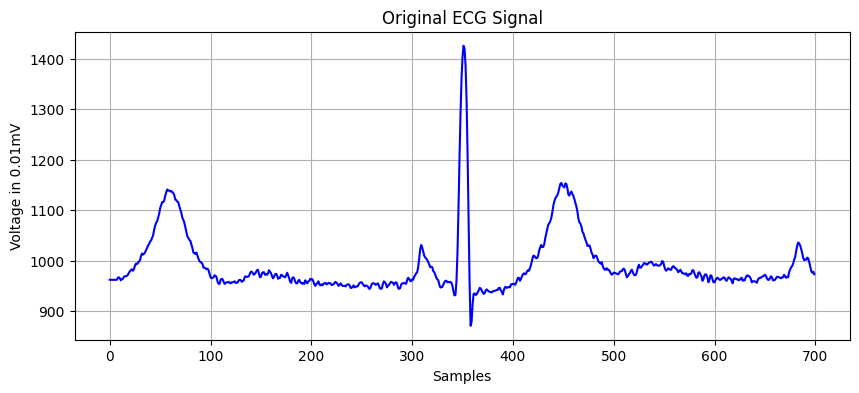

In [12]:
# Plot the original ECG signal
plt.figure(figsize=(10, 4))
plt.plot(temp_signal[:700], color='blue')
plt.title('Original ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Voltage in 0.01mV')
plt.grid()
plt.savefig('original_ecg_signal.png')
plt.show()

In [13]:
temp2signal=temp_signal

In [14]:
def denoise(data):
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
  #  print(len(coeffs))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))

    datarec = pywt.waverec(coeffs, 'sym4')
    return datarec

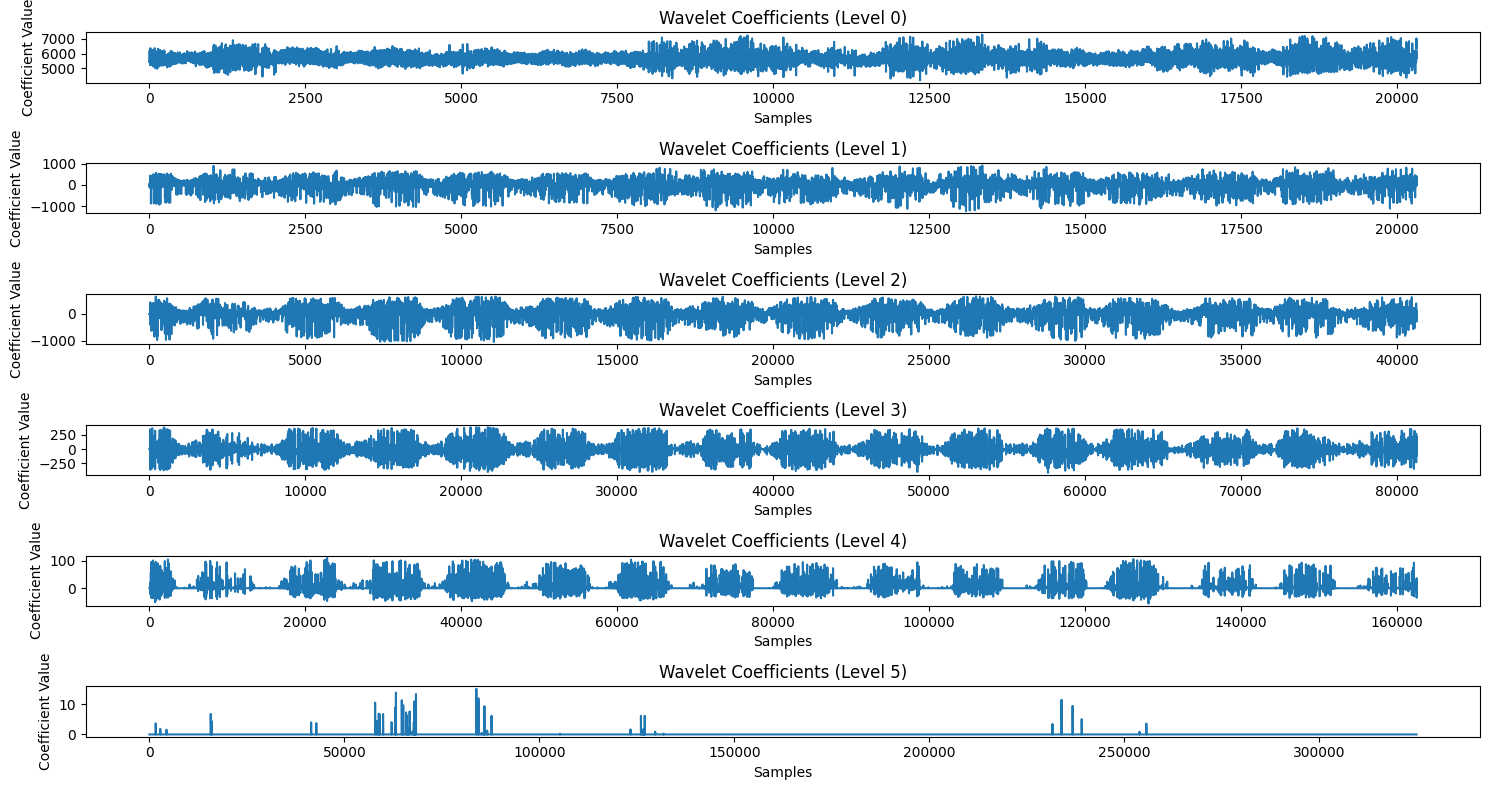

In [15]:
# Get wavelet coefficients before and after denoising
w = pywt.Wavelet('sym4')
coeffs = pywt.wavedec(temp_signal, 'sym4', level=5)

# Thresholding
threshold = 0.04 * max(coeffs[1])
for i in range(1, len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold)

# Denoised signal reconstruction
datarec = pywt.waverec(coeffs, 'sym4')

# Plot wavelet coefficients
plt.figure(figsize=(15, 8))
for i, coeff in enumerate(coeffs):
    plt.subplot(len(coeffs), 1, i + 1)
    plt.plot(coeff)
    plt.title(f'Wavelet Coefficients (Level {i})')
    plt.xlabel('Samples')
    plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.savefig('wavelet_coefficients.png')
plt.show()

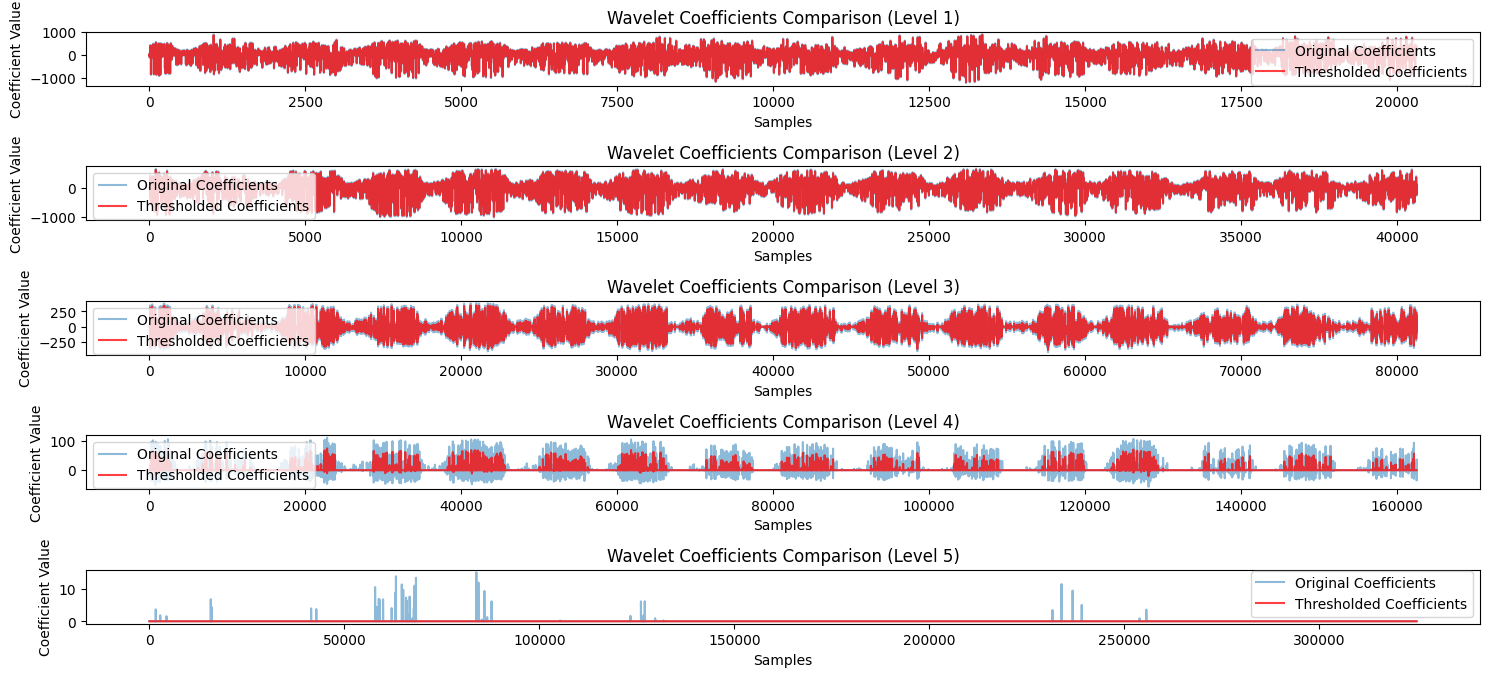

In [16]:
# Thresholding process visualization
threshold = 0.04 * max(coeffs[1])
coeffs_thresholded = coeffs.copy()

for i in range(1, len(coeffs)):
    coeffs_thresholded[i] = pywt.threshold(coeffs[i], threshold)

# Plot original vs. thresholded coefficients
plt.figure(figsize=(15, 8))
for i in range(1, len(coeffs)):
    plt.subplot(len(coeffs), 1, i + 1)
    plt.plot(coeffs[i], label='Original Coefficients', alpha=0.5)
    plt.plot(coeffs_thresholded[i], label='Thresholded Coefficients', color='red', alpha=0.75)
    plt.title(f'Wavelet Coefficients Comparison (Level {i})')
    plt.xlabel('Samples')
    plt.ylabel('Coefficient Value')
    plt.legend()

plt.tight_layout()
plt.savefig('thresholding_process.png')
plt.show()

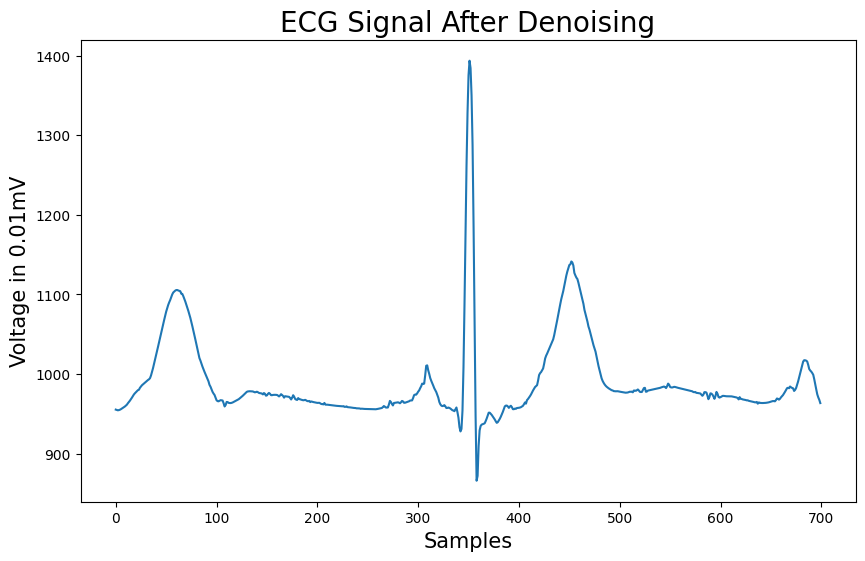

In [17]:
temp_signal=denoise(temp_signal)
plt.plot(temp_signal[:700])
plt.title('ECG Signal After Denoising',fontsize=20)
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage in 0.01mV', fontsize=15)
plt.savefig('after_denoising')

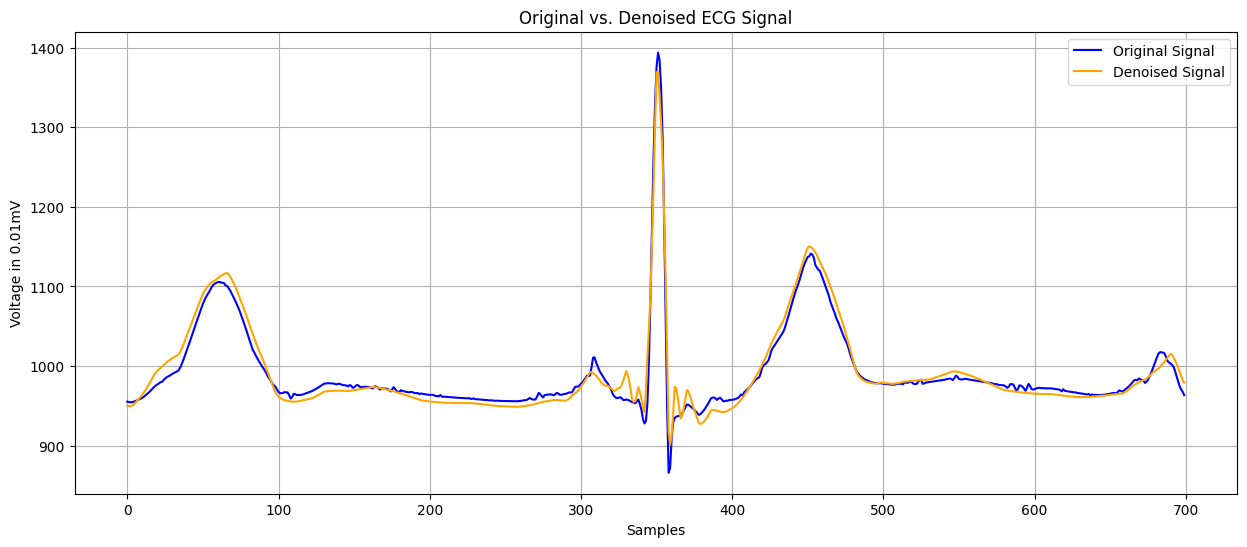

In [18]:
# Denoised signal reconstruction
datarec = pywt.waverec(coeffs_thresholded, 'sym4')

# Plot original vs. denoised signal
plt.figure(figsize=(15, 6))
plt.plot(temp_signal[:700], label='Original Signal', color='blue')
plt.plot(datarec[:700], label='Denoised Signal', color='orange')
plt.title('Original vs. Denoised ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Voltage in 0.01mV')
plt.legend()
plt.grid()
plt.savefig('denoised_ecg_signal.png')
plt.show()

Mean Squared Error (MSE): 158.04299627746116


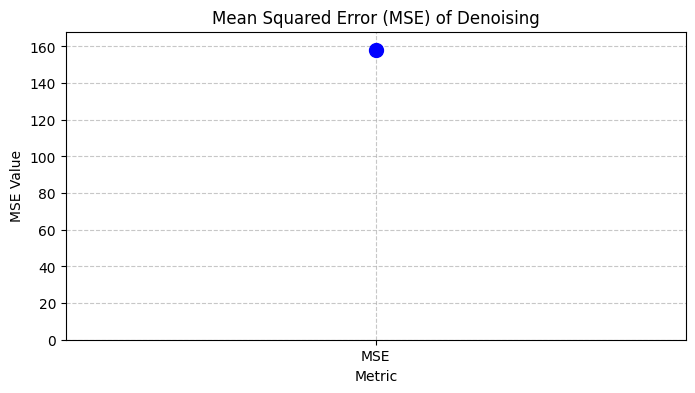

In [19]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Calculate MSE between the original and denoised signals
mse = mean_squared_error(temp_signal, datarec)
print("Mean Squared Error (MSE):", mse)

# Plotting the MSE in a line plot with a marker
plt.figure(figsize=(8, 4))
plt.plot(['MSE'], [mse], marker='o', color='b', markersize=10, linewidth=2)
plt.title('Mean Squared Error (MSE) of Denoising')
plt.xlabel('Metric')
plt.ylabel('MSE Value')
plt.ylim(0, mse + 10)  # Set y-axis range slightly above the MSE value for clear visibility
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('mse_line_plot.png')
plt.show()


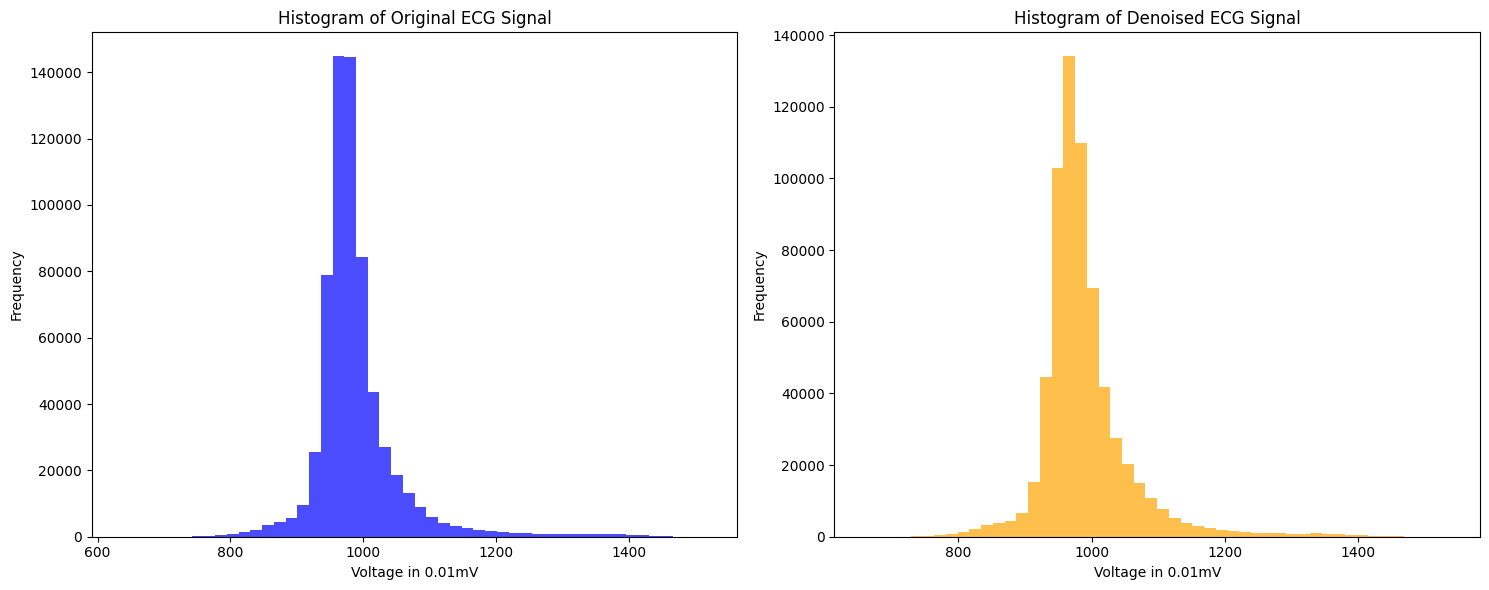

In [20]:
# Plot histograms of original and denoised signals
plt.figure(figsize=(15, 6))

# Original signal histogram
plt.subplot(1, 2, 1)
plt.hist(temp_signal, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Original ECG Signal')
plt.xlabel('Voltage in 0.01mV')
plt.ylabel('Frequency')

# Denoised signal histogram
plt.subplot(1, 2, 2)
plt.hist(datarec, bins=50, color='orange', alpha=0.7)
plt.title('Histogram of Denoised ECG Signal')
plt.xlabel('Voltage in 0.01mV')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('original_vs_denoised_histogram.png')
plt.show()


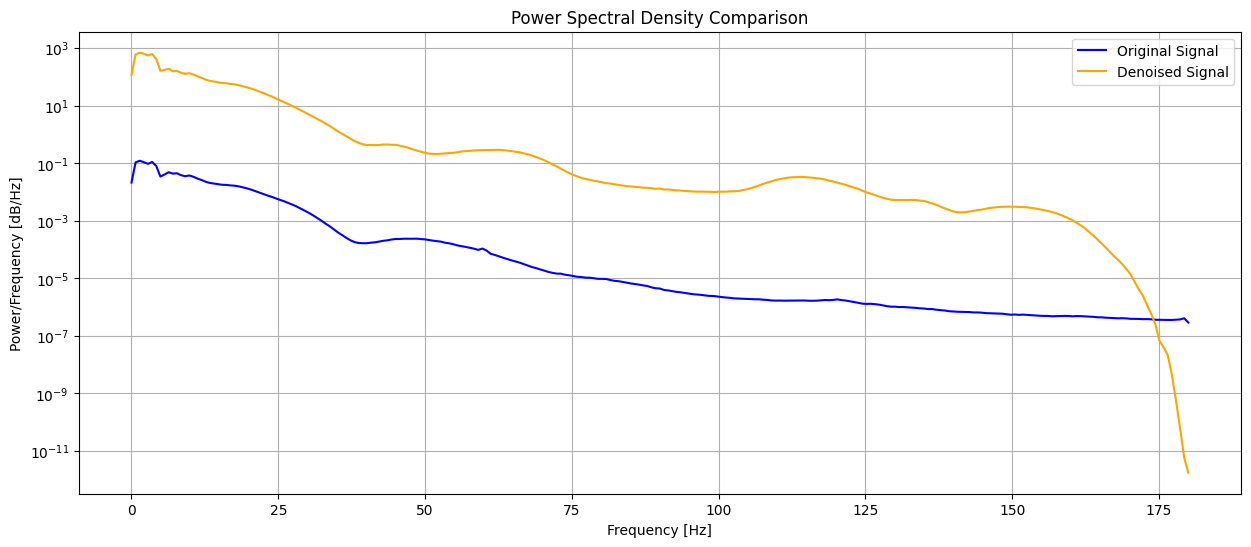

In [25]:
from scipy.signal import welch

# Calculate the power spectral density
frequencies, psd_original = welch(temp_signal, fs=360, nperseg=512)
frequencies, psd_denoised = welch(datarec, fs=360, nperseg=512)

# Plot PSD comparison
plt.figure(figsize=(15, 6))
plt.semilogy(frequencies, psd_original, label='Original Signal', color='blue')
plt.semilogy(frequencies, psd_denoised, label='Denoised Signal', color='orange')
plt.title('Power Spectral Density Comparison')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.legend()
plt.grid()
plt.savefig('psd_comparison.png')
plt.show()


Normalization

In [22]:
temp_signal = stats.zscore(temp_signal)

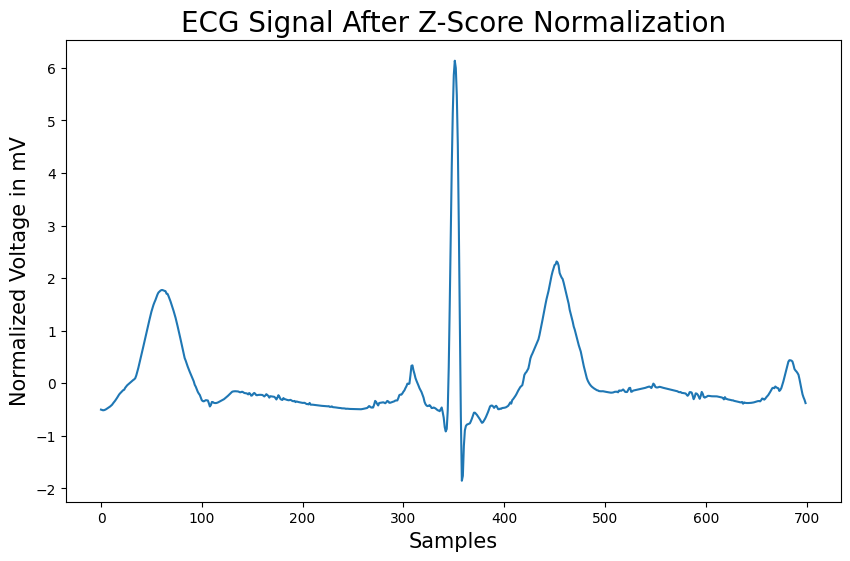

In [23]:
plt.plot(temp_signal[:700])
plt.title('ECG Signal After Z-Score Normalization',fontsize=20)
plt.xlabel('Samples',fontsize=15)
plt.ylabel('Normalized Voltage in mV',fontsize=15)
plt.savefig('after_norm')

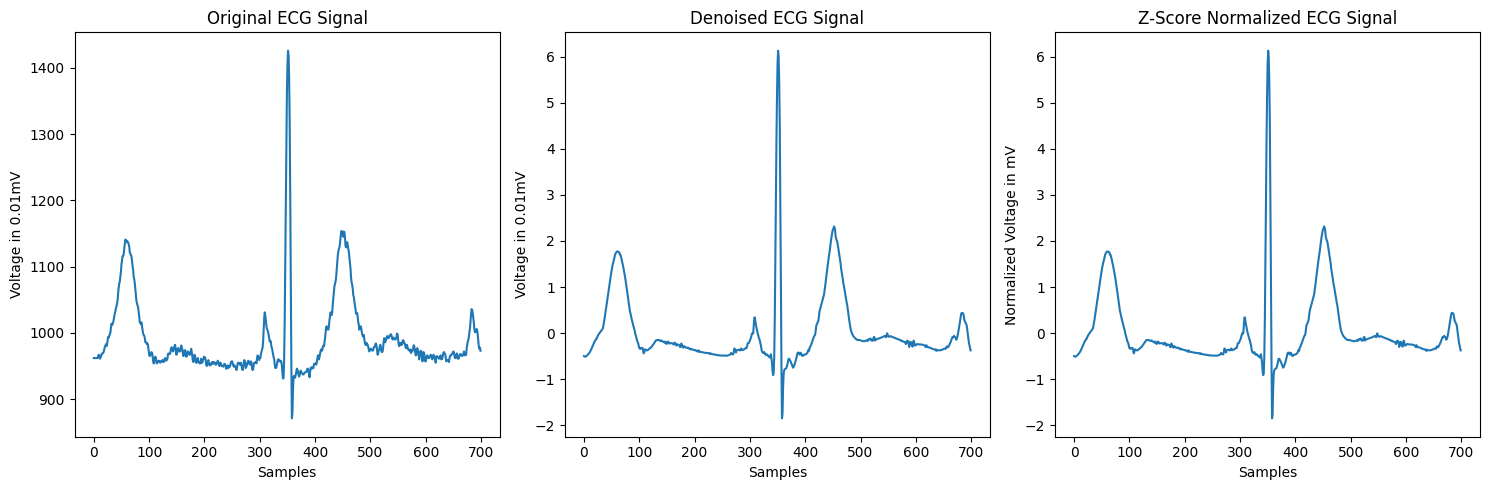

In [24]:
# Analyzing the effect of denoising and normalization
plt.figure(figsize=(15, 5))

# Original signal
plt.subplot(1, 3, 1)
plt.plot(temp2signal[:700])
plt.title('Original ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Voltage in 0.01mV')

# Denoised signal
plt.subplot(1, 3, 2)
plt.plot(temp_signal[:700])
plt.title('Denoised ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Voltage in 0.01mV')

# Normalized signal
plt.subplot(1, 3, 3)
plt.plot(stats.zscore(temp_signal)[:700])
plt.title('Z-Score Normalized ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Normalized Voltage in mV')

plt.tight_layout()
plt.savefig('preprocessing_analysis.png')
plt.show()

Class distribution

In [26]:
X=list()
y=list()
window_size=180
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1


    signals = denoise(signals)
    #signals = signals.reshape(-1,1)
    signals = stats.zscore(signals)

    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()

        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted)
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)

            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

(100012, 360) (100012,)


In [27]:
count_classes

[75052, 8075, 7259, 2546, 7130]

In [28]:
# Overview of the dataset
print(f"Total records in dataset: {len(records)}")
print(f"Total classes: {n_classes}")
print("Class labels: ", classes)

Total records in dataset: 48
Total classes: 5
Class labels:  ['N', 'L', 'R', 'A', 'V']


0
0    75011
1     8071
2     7255
4     7129
3     2546
Name: count, dtype: int64


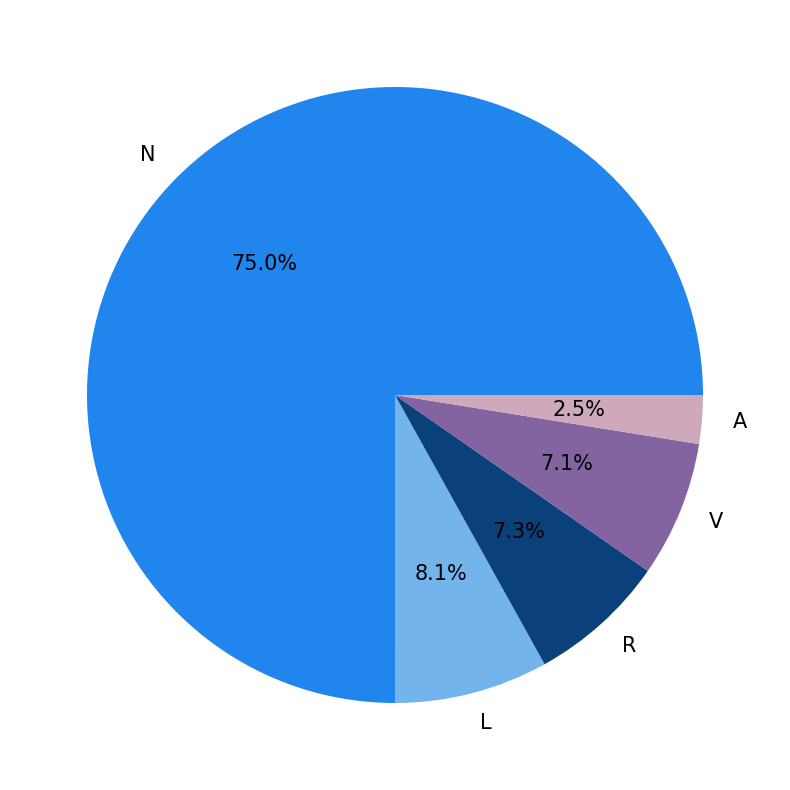

<Figure size 1000x600 with 0 Axes>

In [30]:
y_df = pd.DataFrame(y)
y_df.head()
per_class = y_df[y_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['#2085ec','#72b4eb','#0a417a','#8464a0','#cea9bc'],autopct='%1.1f%%', textprops={'fontsize':15})

plt.show()
# The original code had p.savefig. p was not assigned. The line below uses plt.savefig instead
plt.savefig('Before_piechart') # Changed p to plt

In [31]:
X = np.array(X)
X_reshaped = X.reshape(-1,360,)
X_reshaped.shape

(100012, 360)

In [32]:
X_df = pd.DataFrame(X_reshaped)
X_df.head()

0         1         2         3         4         5         6    \
0  0.018228  0.022953  0.058424  0.077107  0.095080  0.105492  0.112325   
1 -0.366827 -0.344524 -0.320039 -0.330324 -0.299629 -0.292238 -0.283900   
2 -0.171359 -0.140344 -0.109854 -0.078079 -0.048978 -0.034990 -0.028194   
3 -0.186526 -0.182575 -0.177326 -0.171800 -0.165320 -0.158725 -0.151677   
4 -0.369240 -0.368380 -0.344557 -0.314211 -0.295571 -0.279271 -0.261415   

        7         8         9    ...       350       351       352       353  \
0  0.116982  0.119703  0.122254  ... -0.014193 -0.013640 -0.013518 -0.012969   
1 -0.275759 -0.267345 -0.257942  ... -0.140757 -0.140611 -0.140669 -0.140735   
2 -0.024550 -0.024222 -0.023859  ... -0.005353  0.001325  0.007875  0.015828   
3 -0.144942 -0.140875 -0.138009  ...  0.014056  0.021386  0.032036  0.043188   
4 -0.243202 -0.221928 -0.200658  ... -0.024847 -0.019342 -0.014265 -0.009238   

        354       355       356       357       358       359  
0 -0.010249 -0.013186 -0.027581  0.010994 -0.026885 -0.020095  
1 -0.141352 -0.140082 -0.136719 -0.144822 -0.139946 -0.142478  
2  0.025088  0.030657  0.026670  0.056487  0.028112  0.028259  
3  0.058269  0.074966  0.076706  0.073569  0.093104  0.116388  
4 -0.004046  0.001153  0.006449  0.011785  0.016524  0.021073  

[5 rows x 360 columns]

In [33]:
X_new_df = pd.concat([X_df,y_df],axis=1)
X_new_df.head()

0         1         2         3         4         5         6    \
0  0.018228  0.022953  0.058424  0.077107  0.095080  0.105492  0.112325   
1 -0.366827 -0.344524 -0.320039 -0.330324 -0.299629 -0.292238 -0.283900   
2 -0.171359 -0.140344 -0.109854 -0.078079 -0.048978 -0.034990 -0.028194   
3 -0.186526 -0.182575 -0.177326 -0.171800 -0.165320 -0.158725 -0.151677   
4 -0.369240 -0.368380 -0.344557 -0.314211 -0.295571 -0.279271 -0.261415   

        7         8         9    ...       351       352       353       354  \
0  0.116982  0.119703  0.122254  ... -0.013640 -0.013518 -0.012969 -0.010249   
1 -0.275759 -0.267345 -0.257942  ... -0.140611 -0.140669 -0.140735 -0.141352   
2 -0.024550 -0.024222 -0.023859  ...  0.001325  0.007875  0.015828  0.025088   
3 -0.144942 -0.140875 -0.138009  ...  0.021386  0.032036  0.043188  0.058269   
4 -0.243202 -0.221928 -0.200658  ... -0.019342 -0.014265 -0.009238 -0.004046   

        355       356       357       358       359  0    
0 -0.013186 -0.027581  0.010994 -0.026885 -0.020095    0  
1 -0.140082 -0.136719 -0.144822 -0.139946 -0.142478    0  
2  0.030657  0.026670  0.056487  0.028112  0.028259    0  
3  0.074966  0.076706  0.073569  0.093104  0.116388    0  
4  0.001153  0.006449  0.011785  0.016524  0.021073    0  

[5 rows x 361 columns]

In [34]:
ax=list(range(361))
X_new_df = X_new_df.set_axis(ax, axis='columns')

In [35]:
df_0=(X_new_df[X_new_df[X_new_df.shape[1]-1]==0]).sample(n=20000,random_state=42)
df_1=X_new_df[X_new_df[X_new_df.shape[1]-1]==1]
df_2=X_new_df[X_new_df[X_new_df.shape[1]-1]==2]
df_3=X_new_df[X_new_df[X_new_df.shape[1]-1]==3]
df_4=X_new_df[X_new_df[X_new_df.shape[1]-1]==4]

df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=125)
df_2_upsample=resample(df_2,replace=True,n_samples=7000,random_state=77)
df_3_upsample=resample(df_3,replace=True,n_samples=7000,random_state=103)
df_4_upsample=resample(df_4,replace=True,n_samples=7000,random_state=59)

X_new_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0    20000
1     7000
2     7000
3     7000
4     7000
Name: count, dtype: int64


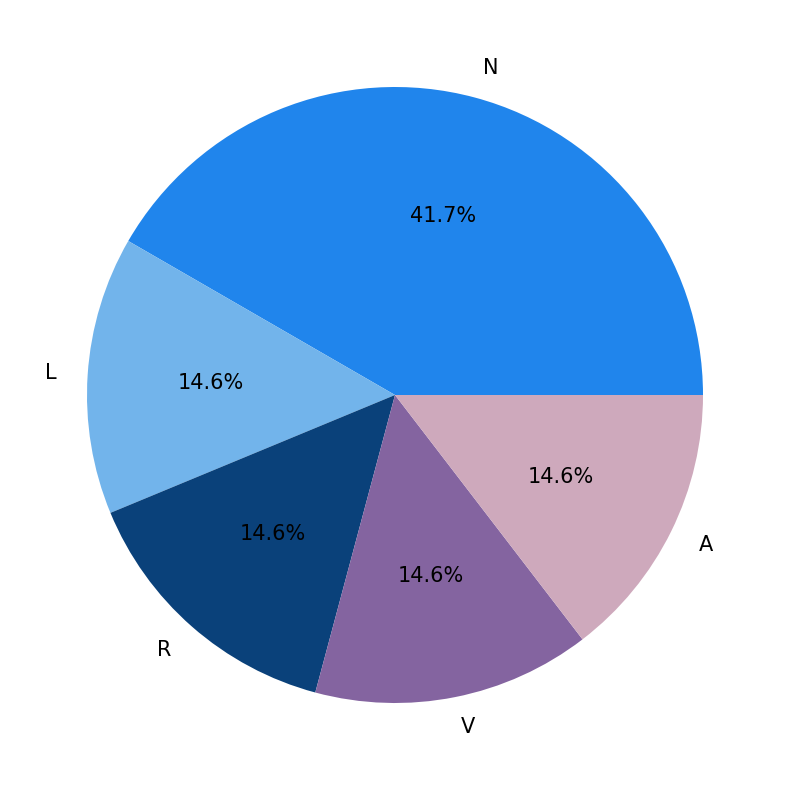

<Figure size 1000x600 with 0 Axes>

In [36]:
per_class = X_new_df[X_new_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['#2085ec','#72b4eb','#0a417a','#8464a0','#cea9bc'],autopct='%1.1f%%',textprops={'fontsize':15})
plt.show()
plt.savefig('after_piechart')

<ipython-input-37-ca0c2fea8da6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=y_df, x=y_df[y_df.shape[1]-1].astype(str), palette='Set2')


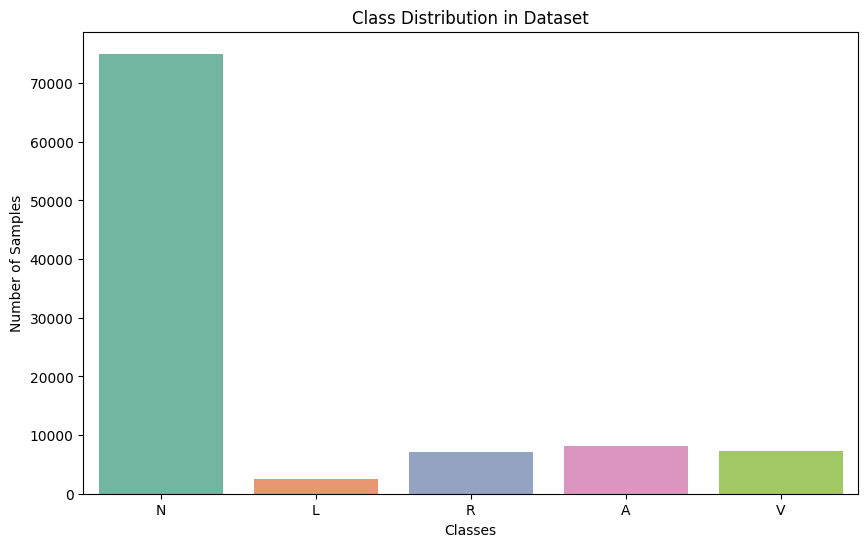

In [37]:
# Distribution of classes in the dataset
plt.figure(figsize=(10, 6))
sns.countplot(data=y_df, x=y_df[y_df.shape[1]-1].astype(str), palette='Set2')
plt.title('Class Distribution in Dataset')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(ticks=np.arange(len(classes)), labels=classes)
plt.savefig('class_distribution.png')
plt.show()

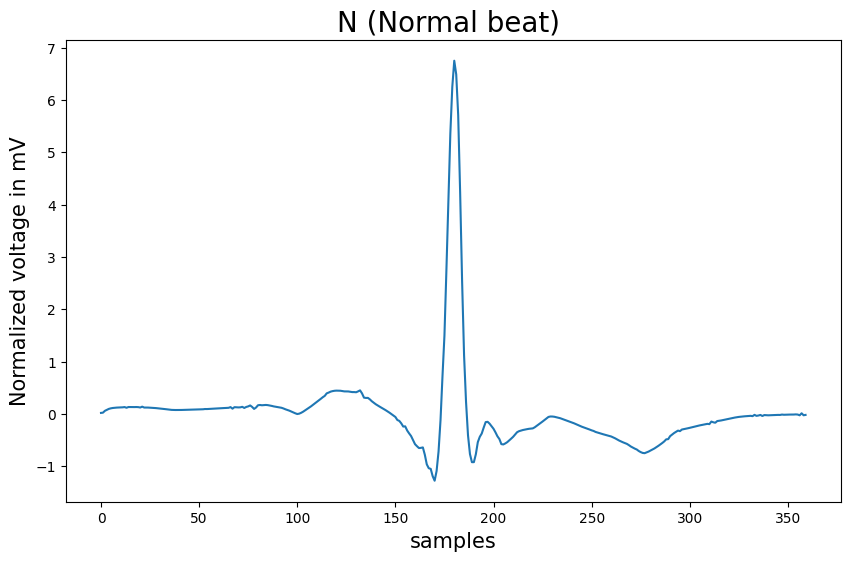

In [38]:
i=0;
while y[i]!=0:
    i=i+1

plt.plot(X[i])
plt.title('N (Normal beat) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('N')

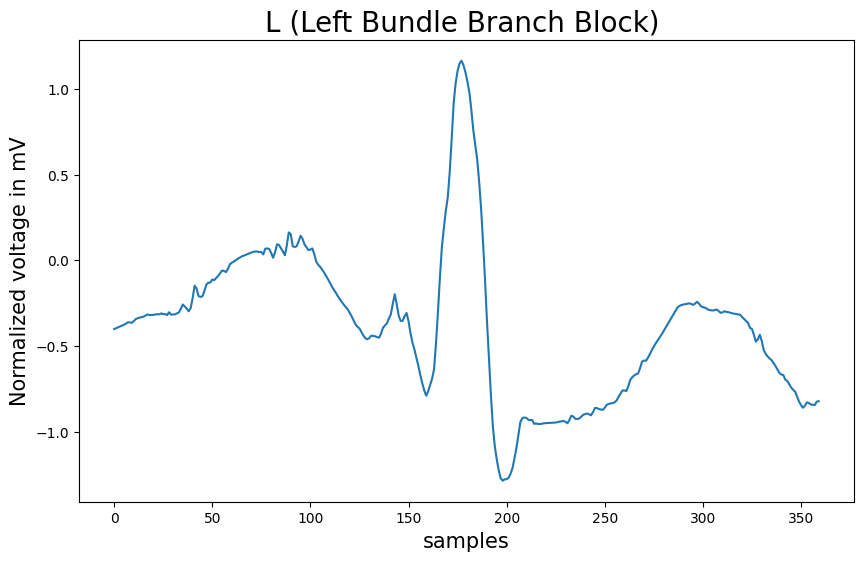

In [39]:
i=0;
while y[i]!=1:
    i=i+1

plt.plot(X[i])
plt.title('L (Left Bundle Branch Block) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('L')

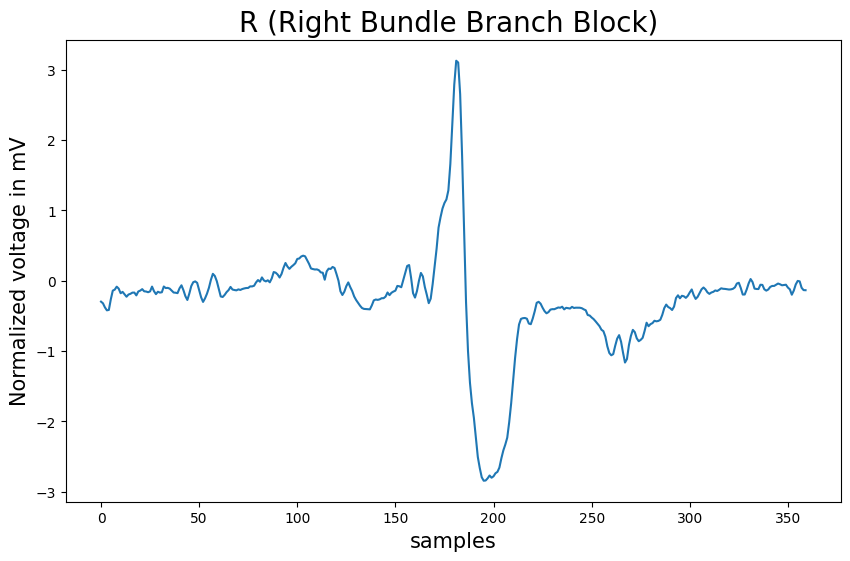

In [40]:
i=0;
while y[i]!=2:
    i=i+1

plt.plot(X[i])
plt.title('R (Right Bundle Branch Block) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('R')

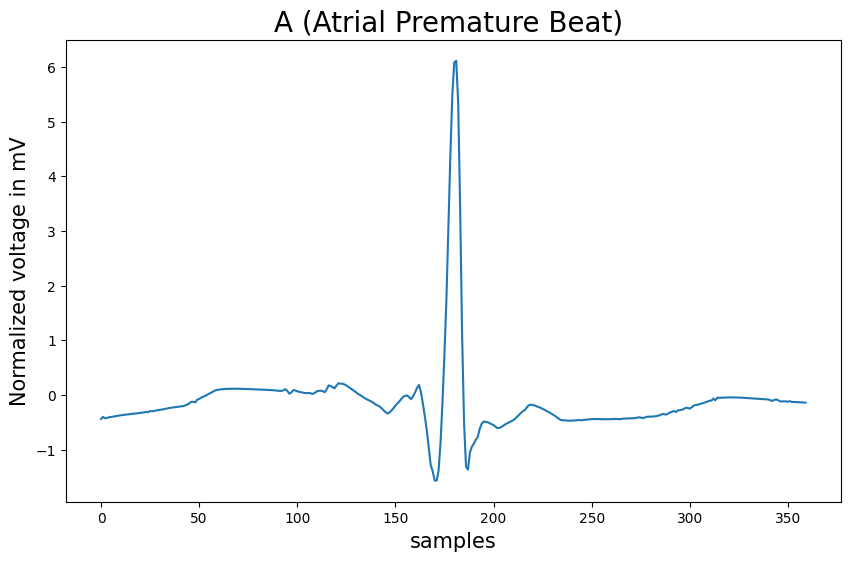

In [41]:
i=0;
while y[i]!=3:
    i=i+1

plt.plot(X[i])
plt.title('A (Atrial Premature Beat) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('A')

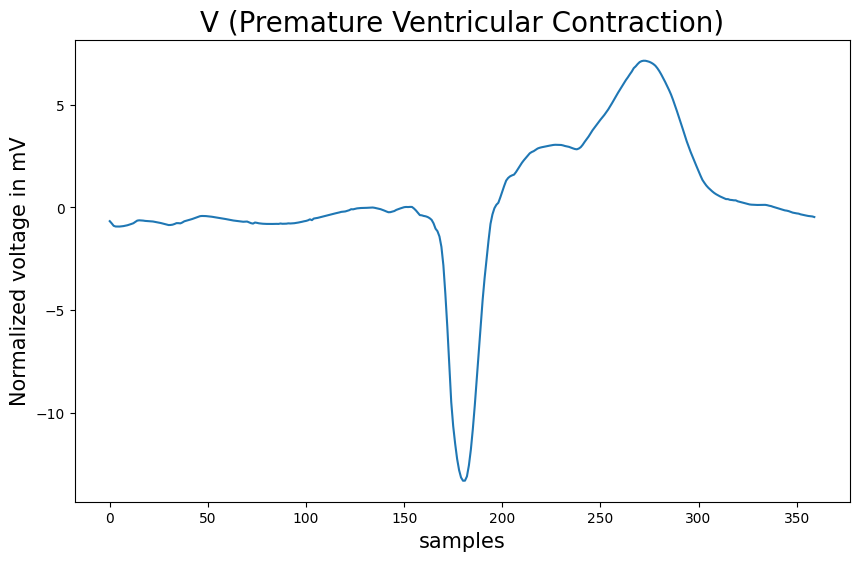

In [42]:
i=0;
while y[i]!=4:
    i=i+1

plt.plot(X[i])
plt.title('V (Premature Ventricular Contraction)', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Normalized voltage in mV',fontsize=15)
plt.savefig('V')

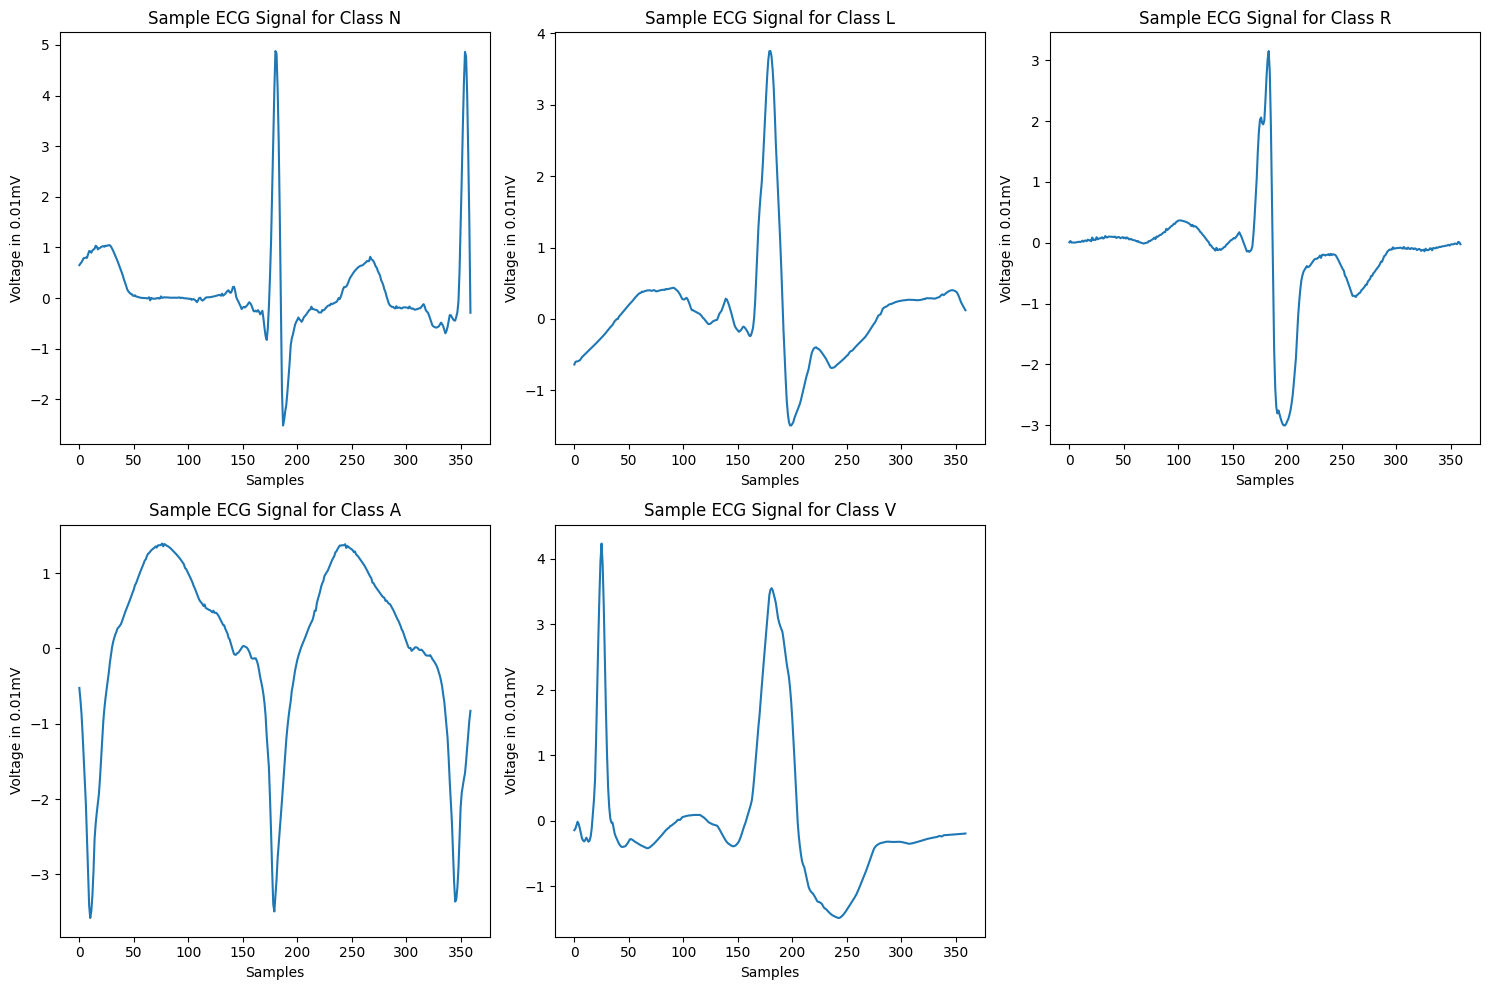

In [43]:
# Plot sample ECG signals from each class
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(classes):
    plt.subplot(2, 3, i + 1)
    samples = X_new_df[X_new_df[X_new_df.shape[1]-1] == i].sample(n=1)  # Get one random sample from each class
    plt.plot(samples.iloc[:, :-1].values.T)
    plt.title(f'Sample ECG Signal for Class {class_name}')
    plt.xlabel('Samples')
    plt.ylabel('Voltage in 0.01mV')
plt.tight_layout()
plt.savefig('sample_ecg_signals.png')
plt.show()


In [44]:
train, test = train_test_split(X_new_df, test_size=0.20, random_state=7)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (38400, 361)
X_test  :  (9600, 361)


In [45]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print(np.shape(y_train), np.shape(y_test))

(38400, 5) (9600, 5)


In [46]:
X_train = train.iloc[:,:train.shape[1]-1].values
X_test = test.iloc[:,:test.shape[1]-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(X_train), np.shape(X_test))

(38400, 360, 1) (9600, 360, 1)


<ipython-input-47-e7415fe57a08>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_df[y_df.shape[1]-1], palette='viridis')
<ipython-input-47-e7415fe57a08>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=per_class_after.index, y=per_class_after.values, palette='viridis')


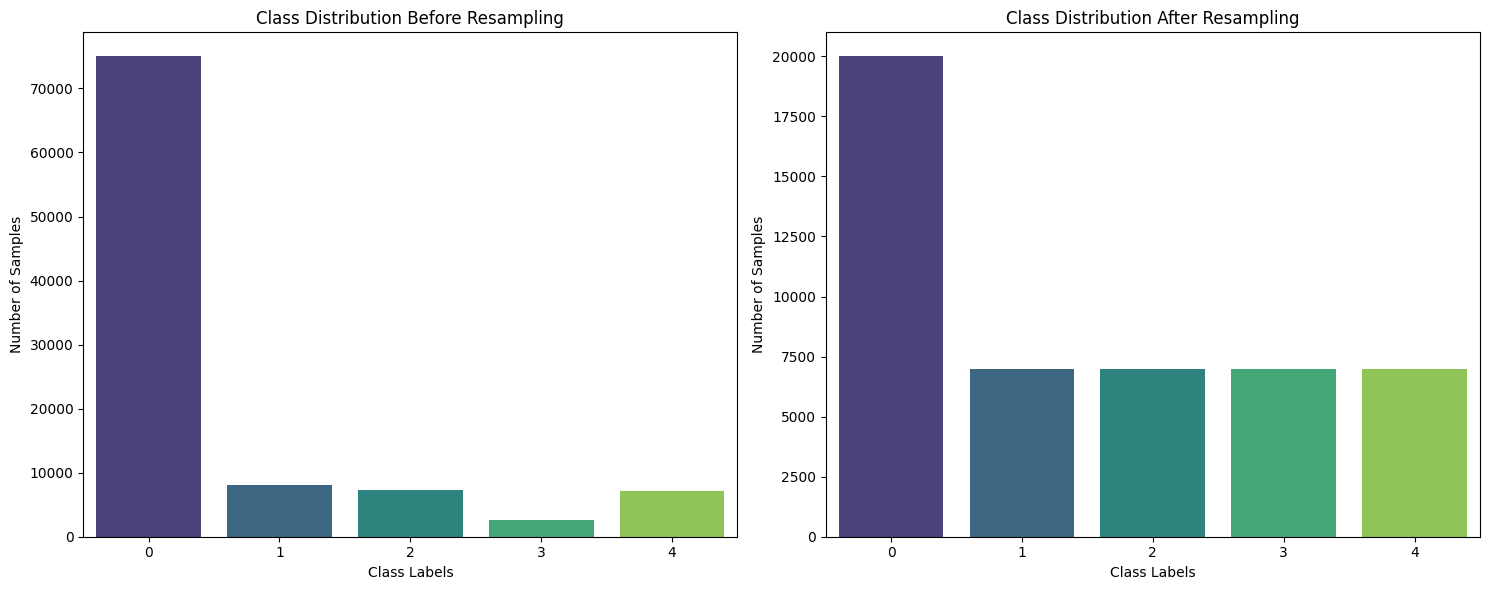

In [47]:
# Class distribution before resampling
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_df[y_df.shape[1]-1], palette='viridis')
plt.title('Class Distribution Before Resampling')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

# Class distribution after resampling
plt.subplot(1, 2, 2)
per_class_after = X_new_df[X_new_df.shape[1]-1].value_counts()
sns.barplot(x=per_class_after.index, y=per_class_after.values, palette='viridis')
plt.title('Class Distribution After Resampling')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

plt.tight_layout()
plt.savefig('class_imbalance_analysis.png')
plt.show()

model

In [48]:
#cnn-bilstm

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# Input shape
input_shape = (360, 1)  # Adjust according to your data

# Define the CNN-BiLSTM model
def create_cnn_bilstm_model(input_shape):
    # ECG Input
    ecg_input = Input(shape=input_shape, name='ecg_input')

    # CNN Layers
    x = Conv1D(filters=32, kernel_size=5, activation='relu')(ecg_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

    # Flatten the output before feeding into LSTM
    x = Flatten()(x)

    # Reshape for LSTM using Keras Reshape layer
    x = Reshape((1, -1))(x)  # Reshape to (batch_size, 1, features)

    # BiLSTM Layer
    x = Bidirectional(LSTM(100, return_sequences=True))(x)
    x = Bidirectional(LSTM(100))(x)

    # Dense Layer with Softmax for classification
    output = Dense(5, activation='softmax')(x)

    # Model Definition
    model = Model(inputs=ecg_input, outputs=output)

    # Model Compilation
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [49]:
# Create and summarize the model
model = create_cnn_bilstm_model(input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ ecg_input (InputLayer)               │ (None, 360, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 356, 32)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 178, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 178, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 174, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 87, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 5568)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 200)              │       4,535,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,005 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,787,501 (18.26 MB)

 Trainable params: 4,787,501 (18.26 MB)

 Non-trainable params: 0 (0.00 B)

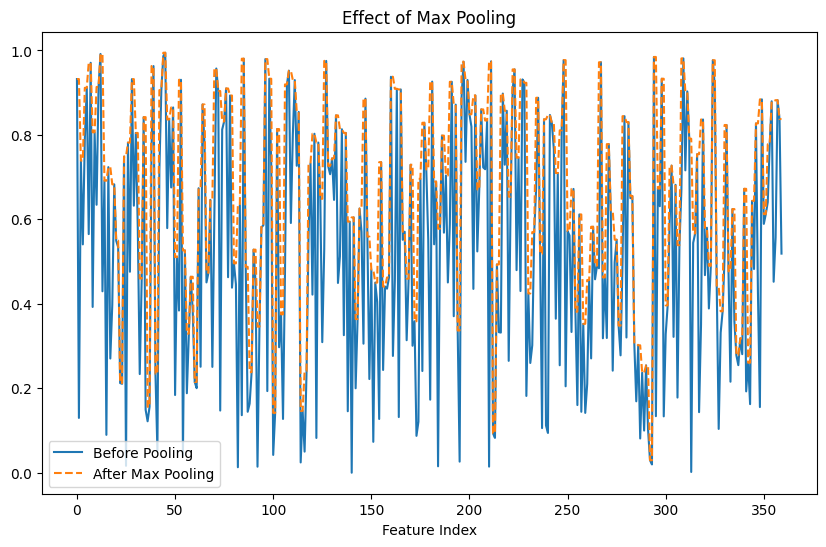

In [50]:
from tensorflow.keras.layers import MaxPooling1D

# Example array to demonstrate max pooling
sample_array = np.random.rand(1, 360, 1)  # Single "image" for demo
max_pool = MaxPooling1D(pool_size=2)
pooled_output = max_pool(sample_array)

# Plotting comparison
plt.plot(sample_array[0], label="Before Pooling")
plt.plot(np.repeat(pooled_output[0], 2), label="After Max Pooling", linestyle='--')
plt.legend()
plt.title("Effect of Max Pooling")
plt.xlabel("Feature Index")
plt.show()

In [51]:
# Flatten the example data
flattened_output = pooled_output.numpy().flatten()

# Reshape for LSTM
reshaped_for_lstm = flattened_output.reshape(1, -1)  # Reshape to (1, features) for LSTM
print("Shape before flatten:", pooled_output.shape)
print("Shape after flatten:", flattened_output.shape)
print("Shape after reshape:", reshaped_for_lstm.shape)

Shape before flatten: (1, 180, 1)
Shape after flatten: (180,)
Shape after reshape: (1, 180)


In [52]:
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential

# Sample data
sample_input = np.random.rand(1, 180, 1)  # Random example data

# BiLSTM Model
model_bilstm = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(180, 1)),
])

# Predict using BiLSTM
bilstm_output = model_bilstm(sample_input)
print("Output shape of BiLSTM:", bilstm_output.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Output shape of BiLSTM: (1, 180, 200)


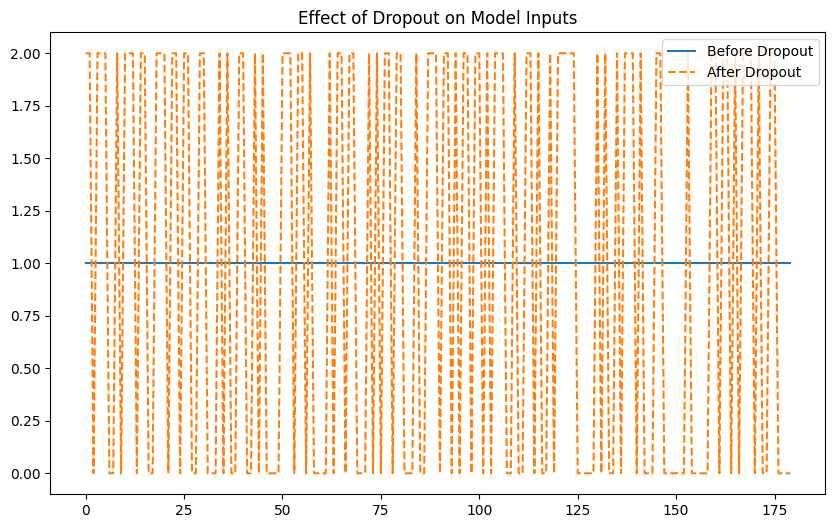

In [53]:
from tensorflow.keras.layers import Dropout

# Example array before dropout
sample_data = np.ones((1, 180, 1))

# Applying dropout
dropout_layer = Dropout(0.5)
output_after_dropout = dropout_layer(sample_data, training=True)

# Plotting the effect
plt.plot(sample_data[0], label="Before Dropout")
plt.plot(output_after_dropout[0], label="After Dropout", linestyle='--')
plt.legend()
plt.title("Effect of Dropout on Model Inputs")
plt.show()

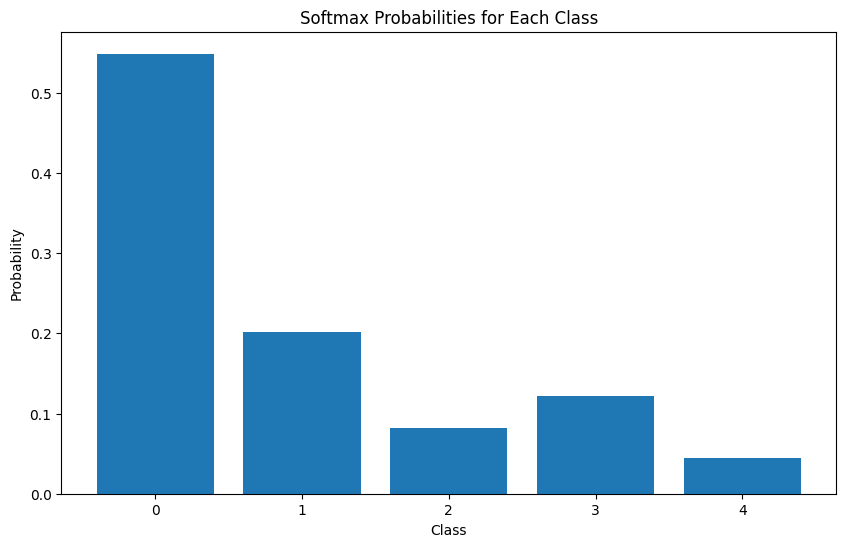

In [54]:
from tensorflow.keras.activations import softmax

# Sample logits for classes
logits = np.array([2.0, 1.0, 0.1, 0.5, -0.5])

# Softmax activation
softmax_probs = softmax(logits).numpy()
plt.bar(range(len(softmax_probs)), softmax_probs)
plt.title("Softmax Probabilities for Each Class")
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


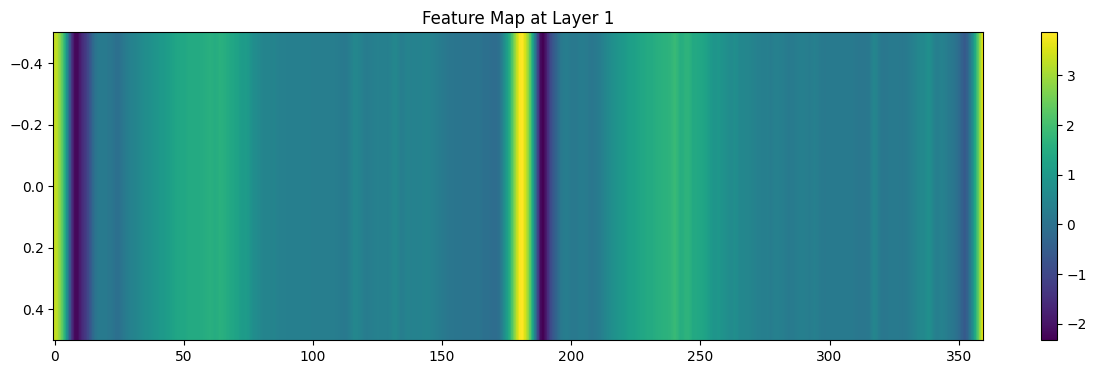

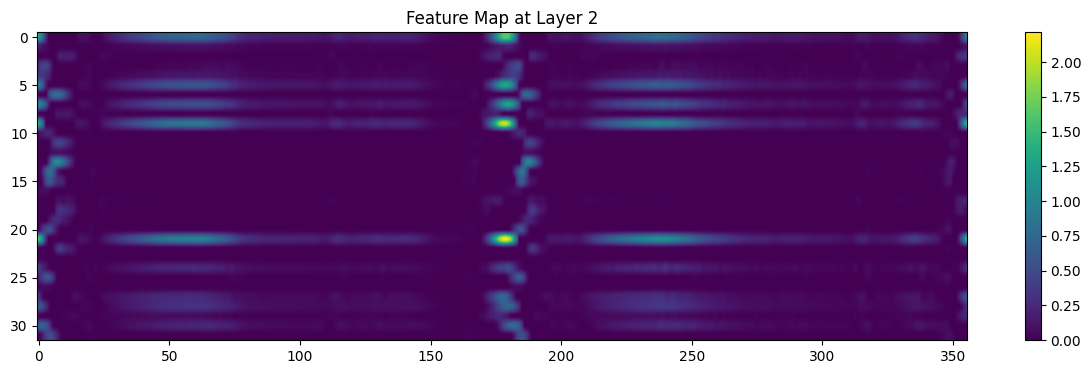

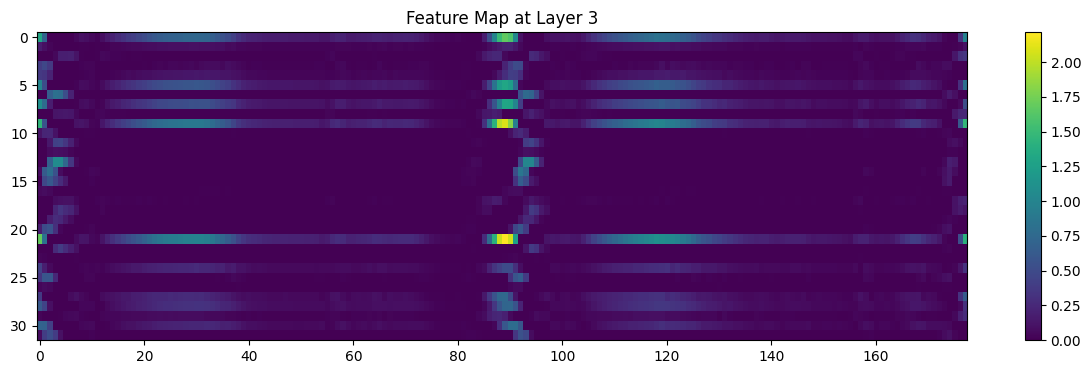

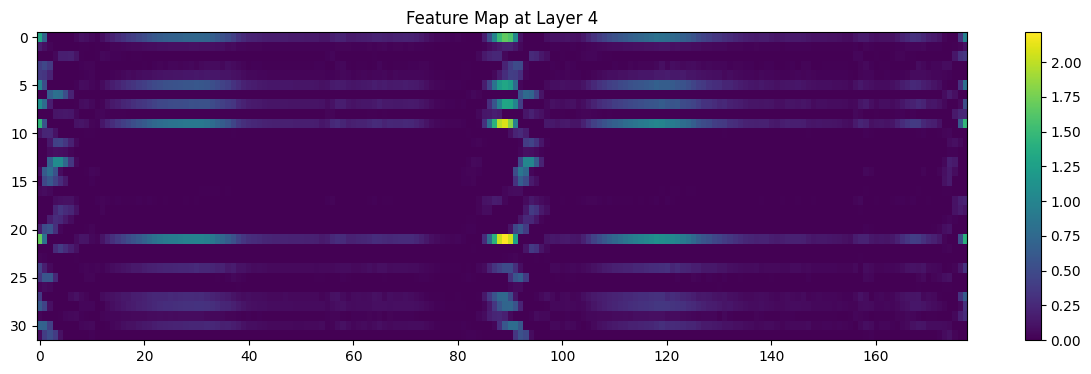

In [55]:
from tensorflow.keras import Model

# Get intermediate layers
layer_outputs = [layer.output for layer in model.layers[:4]]
feature_extractor = Model(inputs=model.input, outputs=layer_outputs)

# Extract features
features = feature_extractor.predict(X_train[:1])  # Assuming X_train is already defined
for idx, feature_map in enumerate(features):
    plt.figure(figsize=(15, 4))
    plt.title(f"Feature Map at Layer {idx + 1}")
    plt.imshow(feature_map[0, :, :].T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.show()


In [59]:
# Model Training (replace X_train, y_train with your actual training data)
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_split=0.2)

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 85s 168ms/step - accuracy: 0.9903 - loss: 0.0292 - val_accuracy: 0.9901 - val_loss: 0.0382
Epoch 2/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 80s 163ms/step - accuracy: 0.9924 - loss: 0.0229 - val_accuracy: 0.9905 - val_loss: 0.0398
Epoch 3/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - accuracy: 0.9926 - loss: 0.0216 - val_accuracy: 0.9891 - val_loss: 0.0404
Epoch 4/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 83s 165ms/step - accuracy: 0.9919 - loss: 0.0229 - val_accuracy: 0.9900 - val_loss: 0.0421
Epoch 5/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 82s 165ms/step - accuracy: 0.9933 - loss: 0.0205 - val_accuracy: 0.9901 - val_loss: 0.0413
Epoch 6/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 82s 165ms/step - accuracy: 0.9942 - loss: 0.0175 - val_accuracy: 0.9906 - val_loss: 0.0444
Epoch 7/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 83s 166ms/step - accuracy: 0.9923 - loss: 0.0203 - val_accuracy: 0.9901 - val_loss: 0.0394
Epoch 8/25
480/480 ━━━━━━━━━━━━━━━━━━━━ 79s 166ms/step - accuracy: 0.9929 - loss: 0

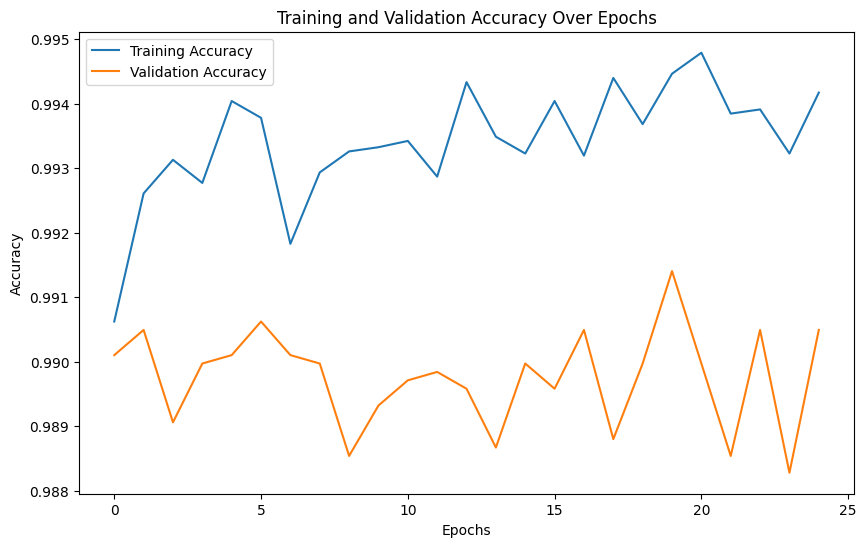

In [60]:
# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.show()

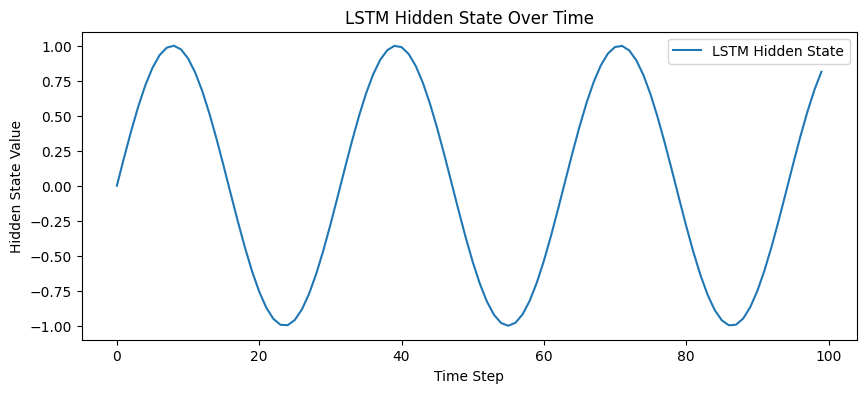

In [62]:
# Generate synthetic hidden state values for demonstration
hidden_states = np.sin(0.2 * np.arange(100))  # Simulate LSTM hidden states

plt.figure(figsize=(10, 4))
plt.plot(hidden_states, label='LSTM Hidden State')
plt.title("LSTM Hidden State Over Time")
plt.xlabel("Time Step")
plt.ylabel("Hidden State Value")
plt.legend()
plt.show()


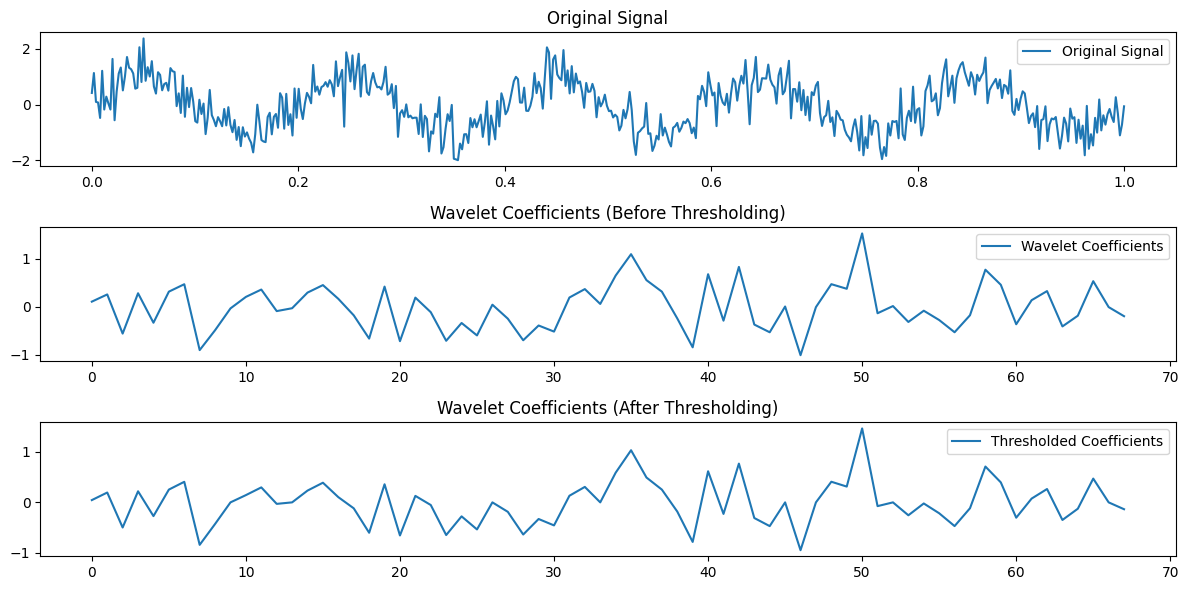

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Generate synthetic ECG signal for demonstration
time = np.linspace(0, 1, 500)
signal = np.sin(2 * np.pi * 5 * time) + 0.5 * np.random.normal(size=time.shape)

# Wavelet Transform
wavelet = 'sym4'
coeffs = pywt.wavedec(signal, wavelet, level=3)
threshold = 0.04 * max(coeffs[1])  # Example threshold

# Thresholding
thresholded_coeffs = [pywt.threshold(c, threshold, mode='soft') if i > 0 else c for i, c in enumerate(coeffs)]

# Plot original signal, wavelet-transformed coefficients, and thresholded coefficients
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time, signal, label='Original Signal')
plt.title("Original Signal")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(coeffs[1], label='Wavelet Coefficients')
plt.title("Wavelet Coefficients (Before Thresholding)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(thresholded_coeffs[1], label='Thresholded Coefficients')
plt.title("Wavelet Coefficients (After Thresholding)")
plt.legend()

plt.tight_layout()
plt.show()


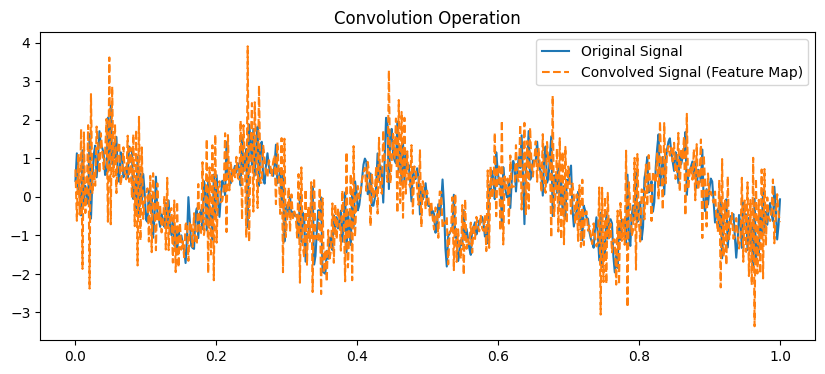

In [65]:
from scipy.signal import convolve

# Simple filter for demonstration
filter_kernel = np.array([1, -1, 1])
conv_output = convolve(signal, filter_kernel, mode='same')

# Plot original signal and convolution output
plt.figure(figsize=(10, 4))
plt.plot(time, signal, label='Original Signal')
plt.plot(time, conv_output, label='Convolved Signal (Feature Map)', linestyle='--')
plt.title("Convolution Operation")
plt.legend()
plt.show()

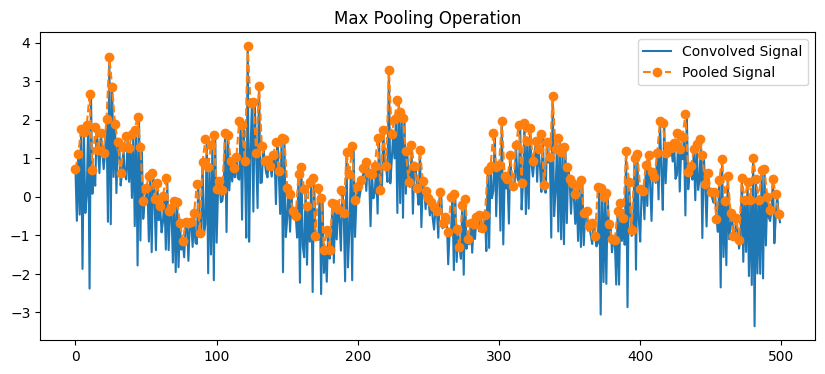

In [66]:
# Max pooling with pool size of 2
pool_size = 2
pooled_output = [max(conv_output[i:i+pool_size]) for i in range(0, len(conv_output), pool_size)]

# Plot original convolved signal and pooled signal
plt.figure(figsize=(10, 4))
plt.plot(conv_output, label='Convolved Signal')
plt.plot(range(0, len(conv_output), pool_size), pooled_output, label='Pooled Signal', linestyle='--', marker='o')
plt.title("Max Pooling Operation")
plt.legend()
plt.show()


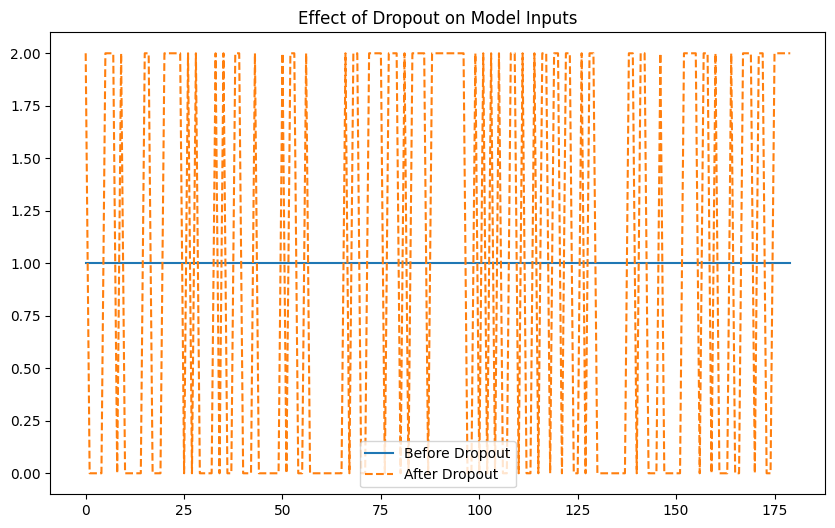

In [ ]:
from tensorflow.keras.layers import Dropout

# Example array before dropout
sample_data = np.ones((1, 180, 1))

# Applying dropout
dropout_layer = Dropout(0.5)
output_after_dropout = dropout_layer(sample_data, training=True)

# Plotting the effect
plt.plot(sample_data[0], label="Before Dropout")
plt.plot(output_after_dropout[0], label="After Dropout", linestyle='--')
plt.legend()
plt.title("Effect of Dropout on Model Inputs")
plt.show()

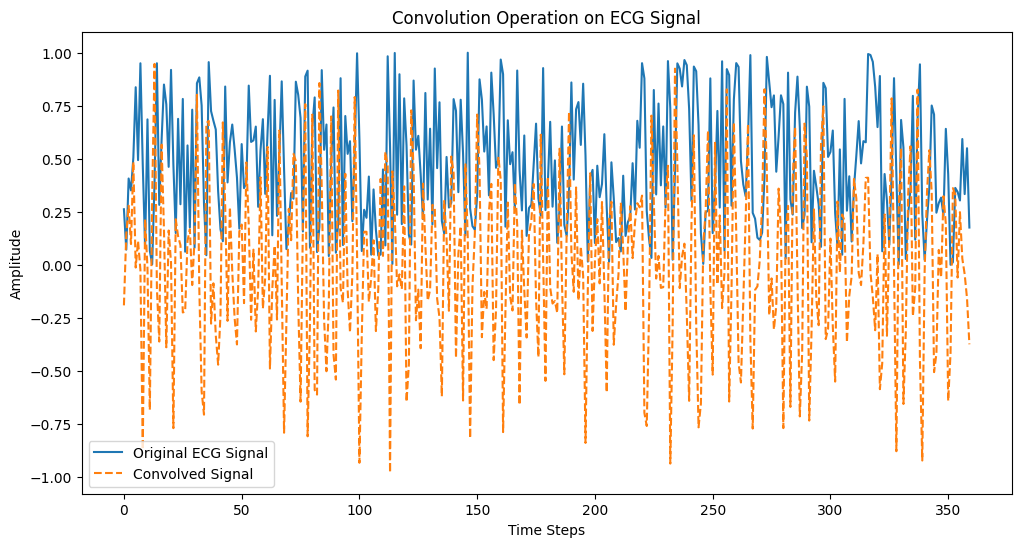

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d

# Example signal
ecg_signal = np.random.rand(360)
kernel = np.array([1, 0, -1])

# Convolution operation
convolved_signal = convolve1d(ecg_signal, kernel)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="Original ECG Signal")
plt.plot(convolved_signal, label="Convolved Signal", linestyle='--')
plt.legend()
plt.title("Convolution Operation on ECG Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.show()

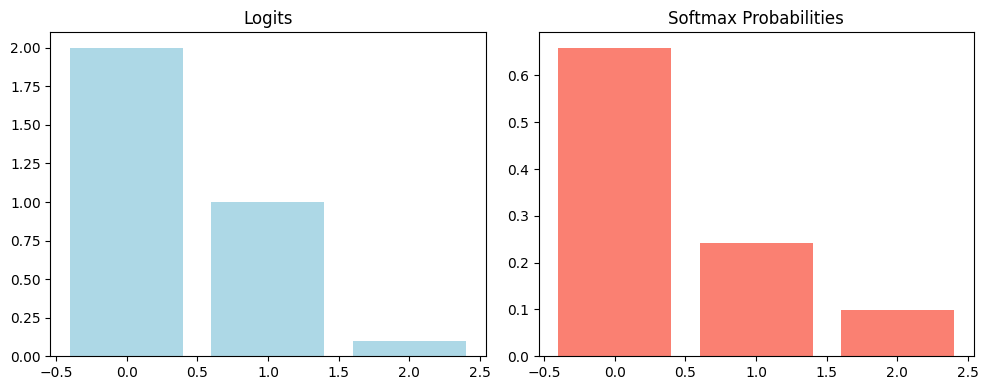

In [68]:
# Softmax function
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

# Example logits
logits = np.array([2.0, 1.0, 0.1])
probabilities = softmax(logits)

# Plot logits and their corresponding softmax probabilities
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(logits)), logits, color='lightblue')
plt.title("Logits")

plt.subplot(1, 2, 2)
plt.bar(range(len(probabilities)), probabilities, color='salmon')
plt.title("Softmax Probabilities")

plt.tight_layout()
plt.show()


300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


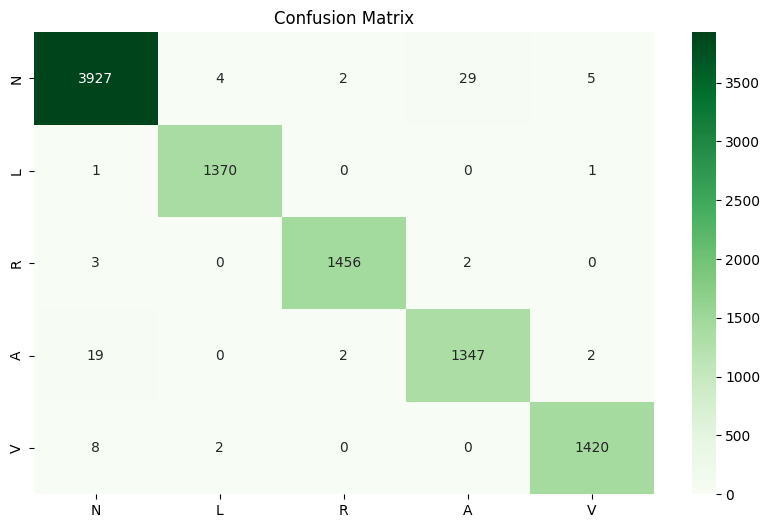

In [69]:
# True labels
y_true = []
for element in y_test:
    y_true.append(np.argmax(element))

# Model Prediction
prediction_proba = model.predict(X_test)
prediction = np.argmax(prediction_proba, axis=1)

# Confusion Matrix
ax = plt.subplot()
custCnnConfMat = confusion_matrix(y_true, prediction)

# Plotting Confusion Matrix
sns.heatmap(custCnnConfMat, annot=True, fmt='d', cmap='Greens', ax=ax)
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)  # Define 'classes' according to your class labels
ax.yaxis.set_ticklabels(classes)  # Define 'classes' according to your class labels
plt.savefig('cm.png')
plt.show()

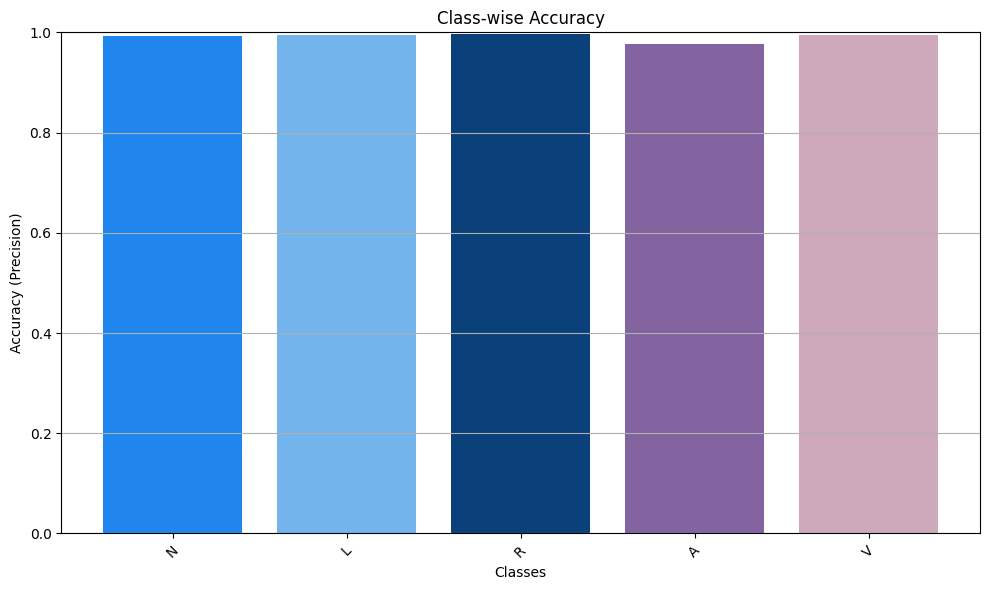

Class: N - Precision: 0.99, Recall: 0.99, F1-score: 0.99
Class: L - Precision: 1.00, Recall: 1.00, F1-score: 1.00
Class: R - Precision: 1.00, Recall: 1.00, F1-score: 1.00
Class: A - Precision: 0.98, Recall: 0.98, F1-score: 0.98
Class: V - Precision: 0.99, Recall: 0.99, F1-score: 0.99


In [70]:
# Calculate precision, recall, and F1 score for each class
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, prediction, target_names=classes, output_dict=True)

# Extracting metrics for each class
class_metrics = {class_name: report[class_name] for class_name in classes}

# Prepare data for plotting
class_names = list(class_metrics.keys())
accuracies = [class_metrics[class_name]['precision'] for class_name in class_names]

# Create a bar plot for class-wise accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_names, accuracies, color=['#2085ec', '#72b4eb', '#0a417a', '#8464a0', '#cea9bc'])
plt.title('Class-wise Accuracy')
plt.xlabel('Classes')
plt.ylabel('Accuracy (Precision)')
plt.ylim(0, 1)  # Set y-axis limits to 0 and 1
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_wise_accuracy.png')  # Save the plot as a PNG file
plt.show()

# Print the class-wise metrics for reference
for class_name, metrics in class_metrics.items():
    print(f"Class: {class_name} - Precision: {metrics['precision']:.2f}, Recall: {metrics['recall']:.2f}, F1-score: {metrics['f1-score']:.2f}")


              precision    recall  f1-score      support
N              0.992168  0.989917  0.991041  3967.000000
L              0.995640  0.998542  0.997089  1372.000000
R              0.997260  0.996578  0.996919  1461.000000
A              0.977504  0.983212  0.980349  1370.000000
V              0.994398  0.993007  0.993702  1430.000000
accuracy       0.991667  0.991667  0.991667     0.991667
macro avg      0.991394  0.992251  0.991820  9600.000000
weighted avg   0.991678  0.991667  0.991670  9600.000000


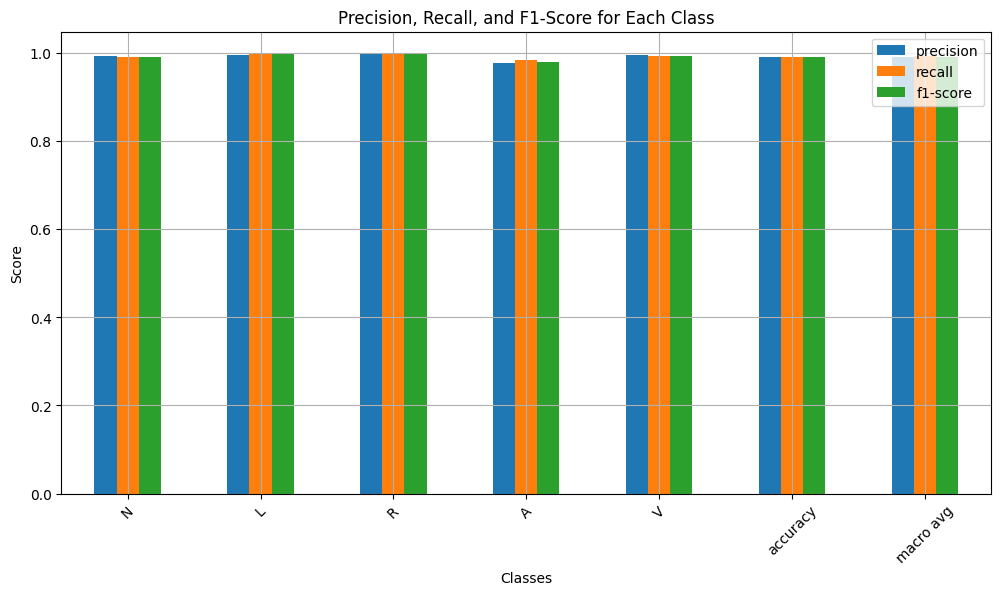

In [71]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, prediction, target_names=classes, output_dict=True)

# Convert report to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Plotting Precision, Recall, and F1-Score
report_df[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(12, 6))
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.ylabel('Score')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('precision_recall_f1.png')
plt.show()

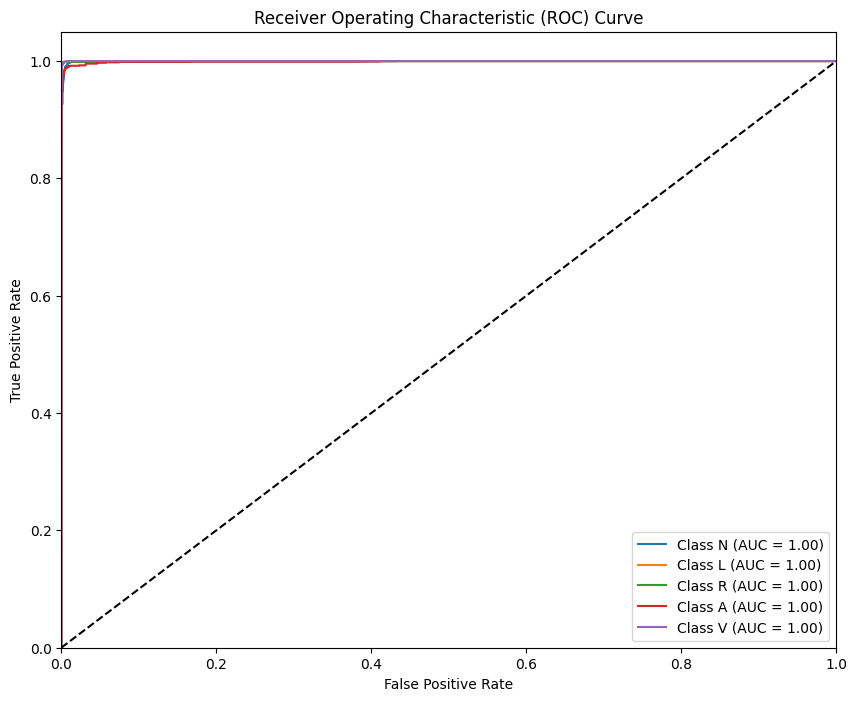

In [72]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], prediction_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')
plt.show()


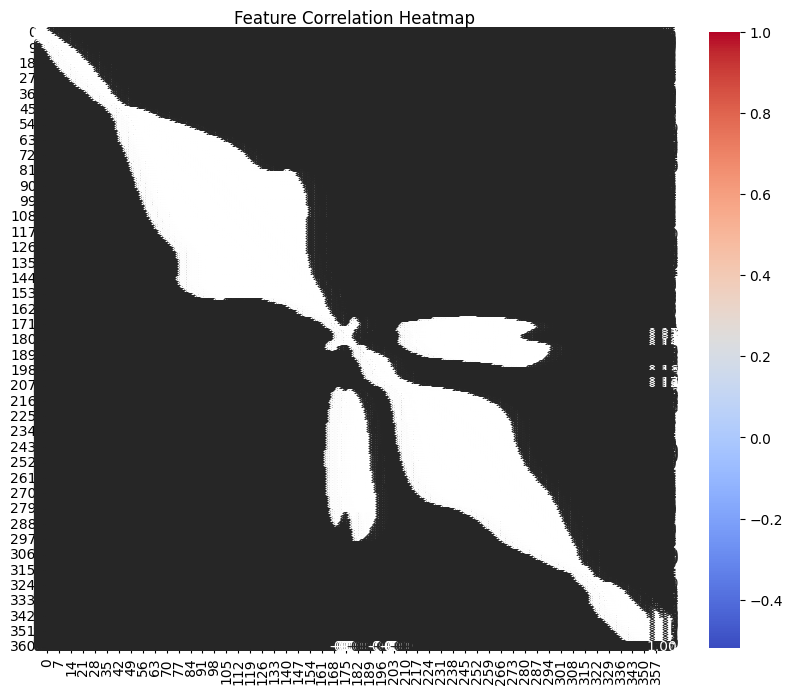

In [73]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = X_new_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

In [74]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier

# Define the Keras model for cross-validation
def create_model():
    model = create_cnn_bilstm_model(input_shape)
    return model

# Wrap model for scikit-learn
model_cv = KerasClassifier(model=create_model, epochs=10, batch_size=32, verbose=0) # Changed build_fn to model

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=7)
cv_scores = cross_val_score(model_cv, X_train, y_train, cv=kf)

# Print cross-validation scores
print("Cross-Validation Scores: ", cv_scores)
print("Mean CV Accuracy: {:.2f}%".format(np.mean(cv_scores) * 100))

Cross-Validation Scores:  [0.98346354 0.98867187 0.98671875 0.9828125  0.98541667]
Mean CV Accuracy: 98.54%


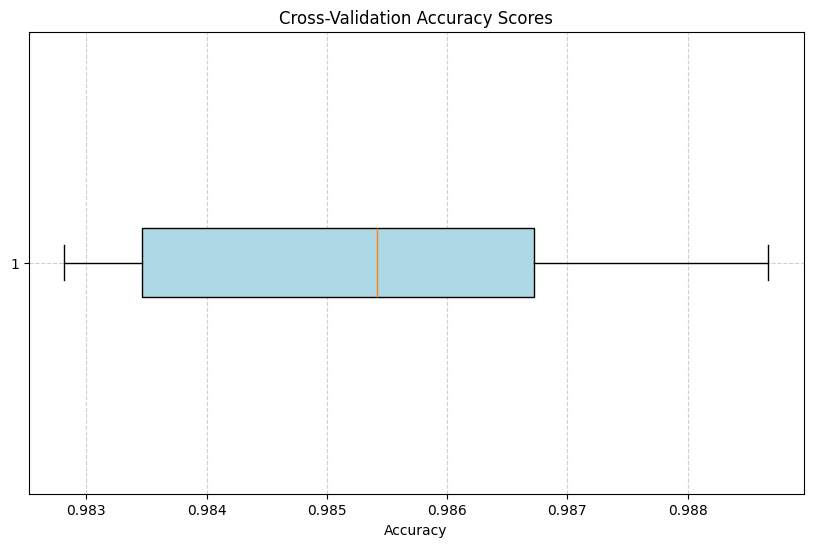

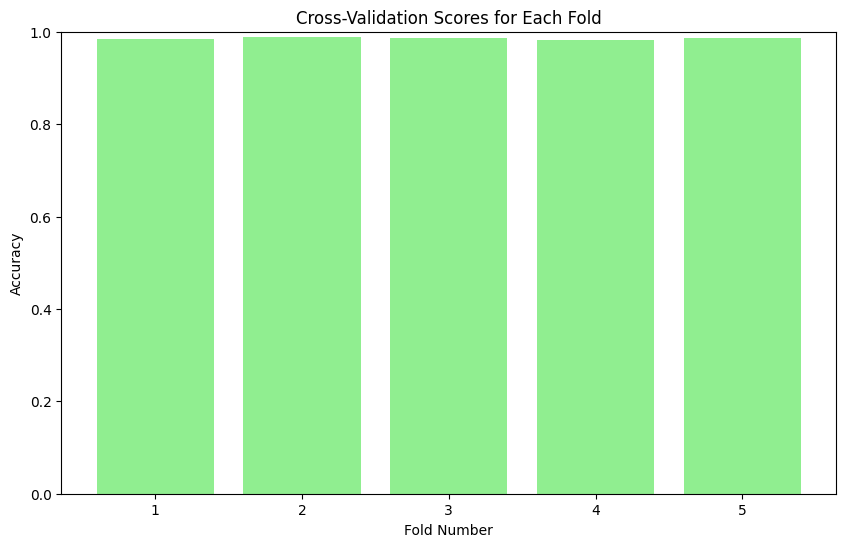

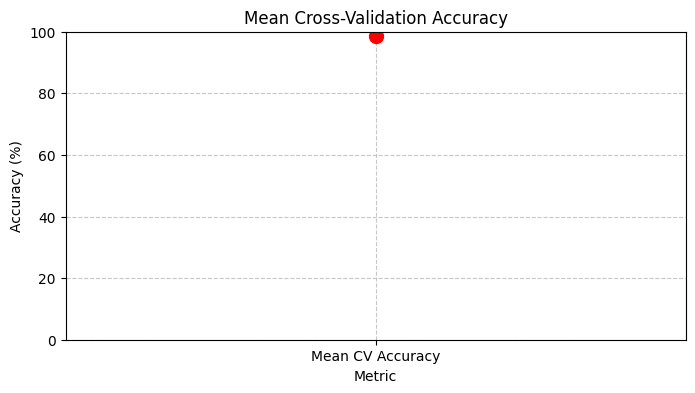

In [ ]:
# Visualization 1: Boxplot of Cross-Validation Scores
plt.figure(figsize=(10, 6))
plt.boxplot(cv_scores, vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title("Cross-Validation Accuracy Scores")
plt.xlabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('cross_validation_boxplot.png')
plt.show()

# Visualization 2: Bar Plot of Cross-Validation Scores
plt.figure(figsize=(10, 6))
plt.bar(range(1, kf.get_n_splits() + 1), cv_scores, color="lightgreen")
plt.title("Cross-Validation Scores for Each Fold")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.xticks(range(1, kf.get_n_splits() + 1))
plt.ylim(0, 1)
plt.savefig('cross_validation_barplot.png')
plt.show()

# Visualization 3: Mean CV Accuracy Line Plot
mean_cv_accuracy = np.mean(cv_scores)
plt.figure(figsize=(8, 4))
plt.plot(['Mean CV Accuracy'], [mean_cv_accuracy * 100], marker='o', color='red', markersize=10, linewidth=2)
plt.title('Mean Cross-Validation Accuracy')
plt.xlabel('Metric')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('mean_cv_accuracy_plot.png')
plt.show()

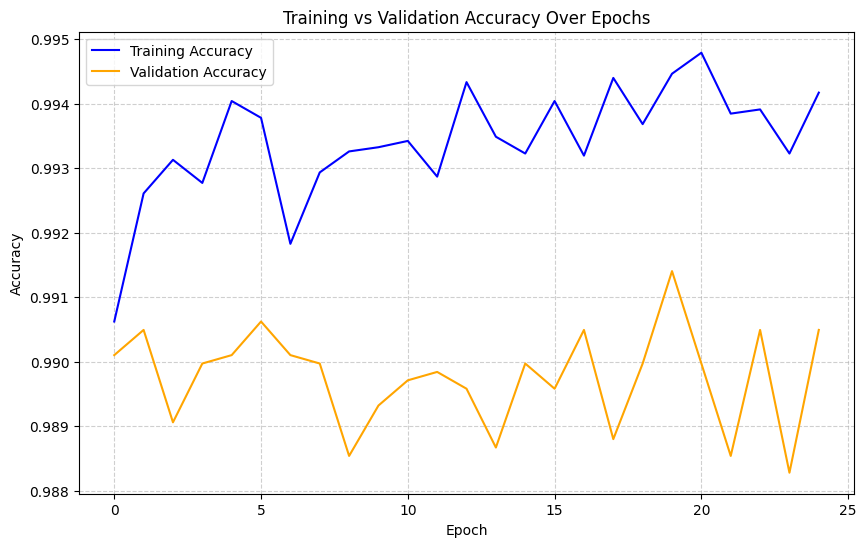

In [ ]:
# Plotting Training vs Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training vs Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('training_vs_validation_accuracy.png')
plt.show()

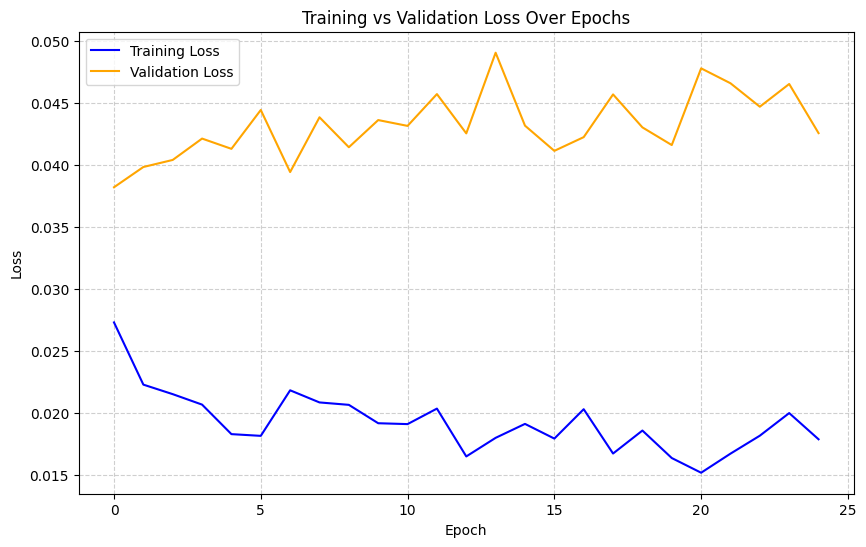

In [ ]:
# Plotting Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('training_vs_validation_loss.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=classes)
print(report)

# Save report to text file
with open('classification_report.txt', 'w') as f:
    f.write(report)

300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
              precision    recall  f1-score   support

           N       0.99      0.99      0.99      3967
           L       1.00      1.00      1.00      1372
           R       1.00      1.00      1.00      1461
           A       0.98      0.98      0.98      1370
           V       0.99      0.99      0.99      1430

    accuracy                           0.99      9600
   macro avg       0.99      0.99      0.99      9600
weighted avg       0.99      0.99      0.99      9600



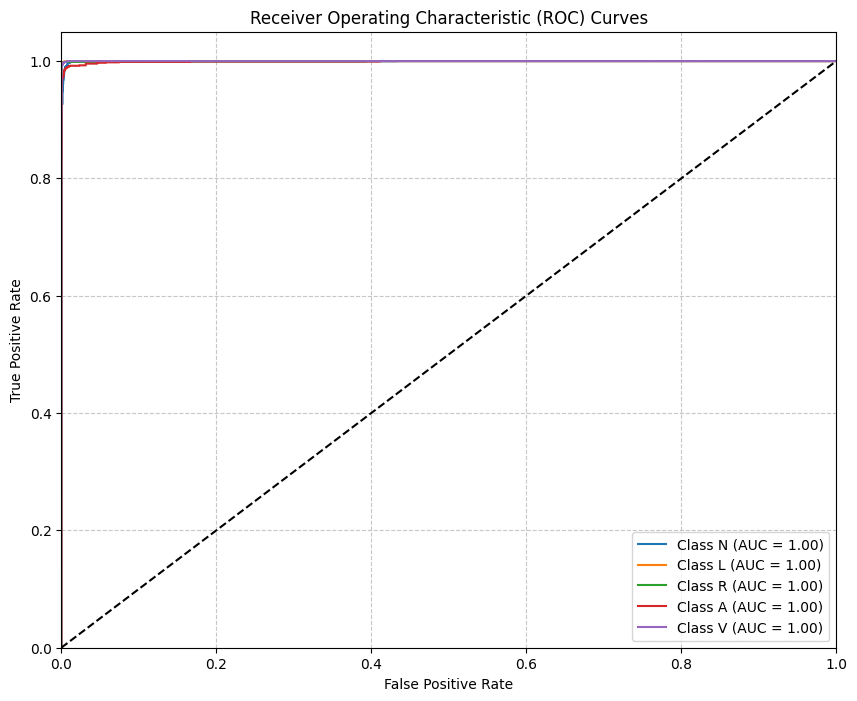

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output labels for ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])  # Adjust classes accordingly
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('roc_curves.png')
plt.show()


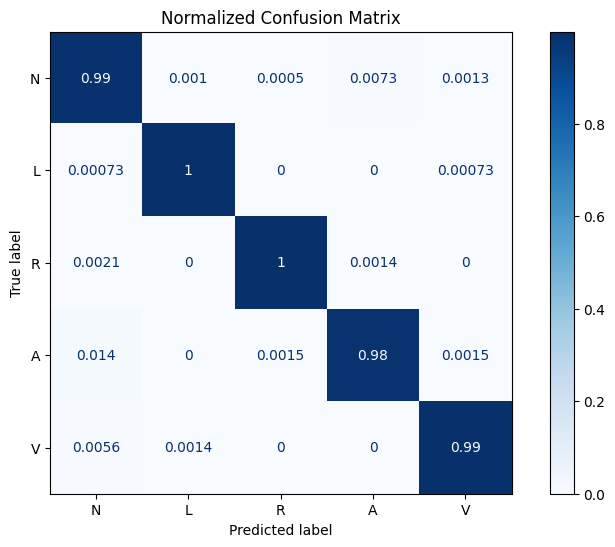

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display normalized confusion matrix
confusion_display = ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes, display_labels=classes, normalize='true', cmap='Blues')
confusion_display.ax_.set_title('Normalized Confusion Matrix')
plt.savefig('normalized_confusion_matrix.png')
plt.show()
